<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>










## 1. Постановка задачи



Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go  

from scipy import stats

import sklearn
import scipy
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error  


from tqdm import tqdm
import time

print(f'Numpy version {np.__version__}')
print(f'Pandas version {pd.__version__}')
print(f'sklearn version {sklearn.__version__}')
print(f'scipy version {scipy.__version__}')

from sklearnex import patch_sklearn, config_context
patch_sklearn()

# # Проверка доступности GPU
# from sklearnex.common.exceptions import DeviceOffloadError
# try:
#     from sklearnex._config import config_context
#     with config_context(target_offload="gpu"):
#         print("GPU доступен для использования")
# except DeviceOffloadError as e:
#     print(f"GPU недоступен: {e}")


Numpy version 1.26.4
Pandas version 2.2.3
sklearn version 1.5.2
scipy version 1.15.1


Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

'Временные рамки данных:'

'Начальная дата: 2016-01-01'

'Конечная дата: 2016-06-30'

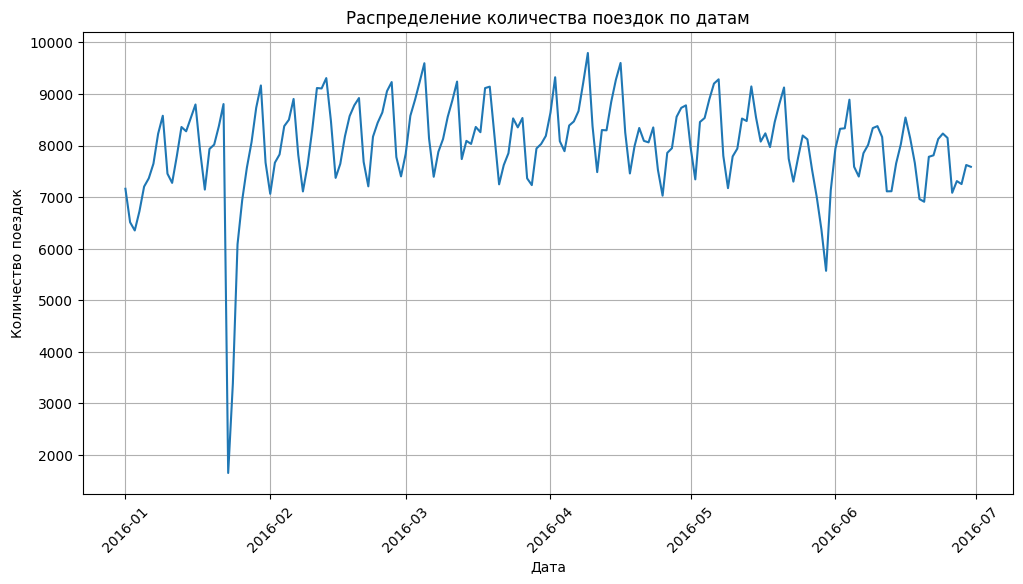

In [4]:
# ваш код здесь
# Преобразование pickup_datetime в datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Определение временных рамок
min_date = taxi_data['pickup_datetime'].dt.date.min()
max_date = taxi_data['pickup_datetime'].dt.date.max()

display(f"Временные рамки данных:")
display(f"Начальная дата: {min_date}")
display(f"Конечная дата: {max_date}")

# Визуализация распределения дат
plt.figure(figsize=(12, 6))
taxi_data['pickup_datetime'].dt.date.value_counts().sort_index().plot()
plt.title('Распределение количества поездок по датам')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
# ваш код здесь
# Подсчет общего количества пропущенных значений
total_missing = taxi_data.isnull().sum().sum()

display(f"Общее количество пропущенных значений во всех столбцах: {total_missing}")

# Для детального анализа выведем количество пропусков по каждому столбцу
missing_by_column = taxi_data.isnull().sum()
display("nКоличество пропущенных значений по столбцам:")
display(missing_by_column)


'Общее количество пропущенных значений во всех столбцах: 0'

'nКоличество пропущенных значений по столбцам:'

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


'Статистические характеристики числовых признаков:'

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


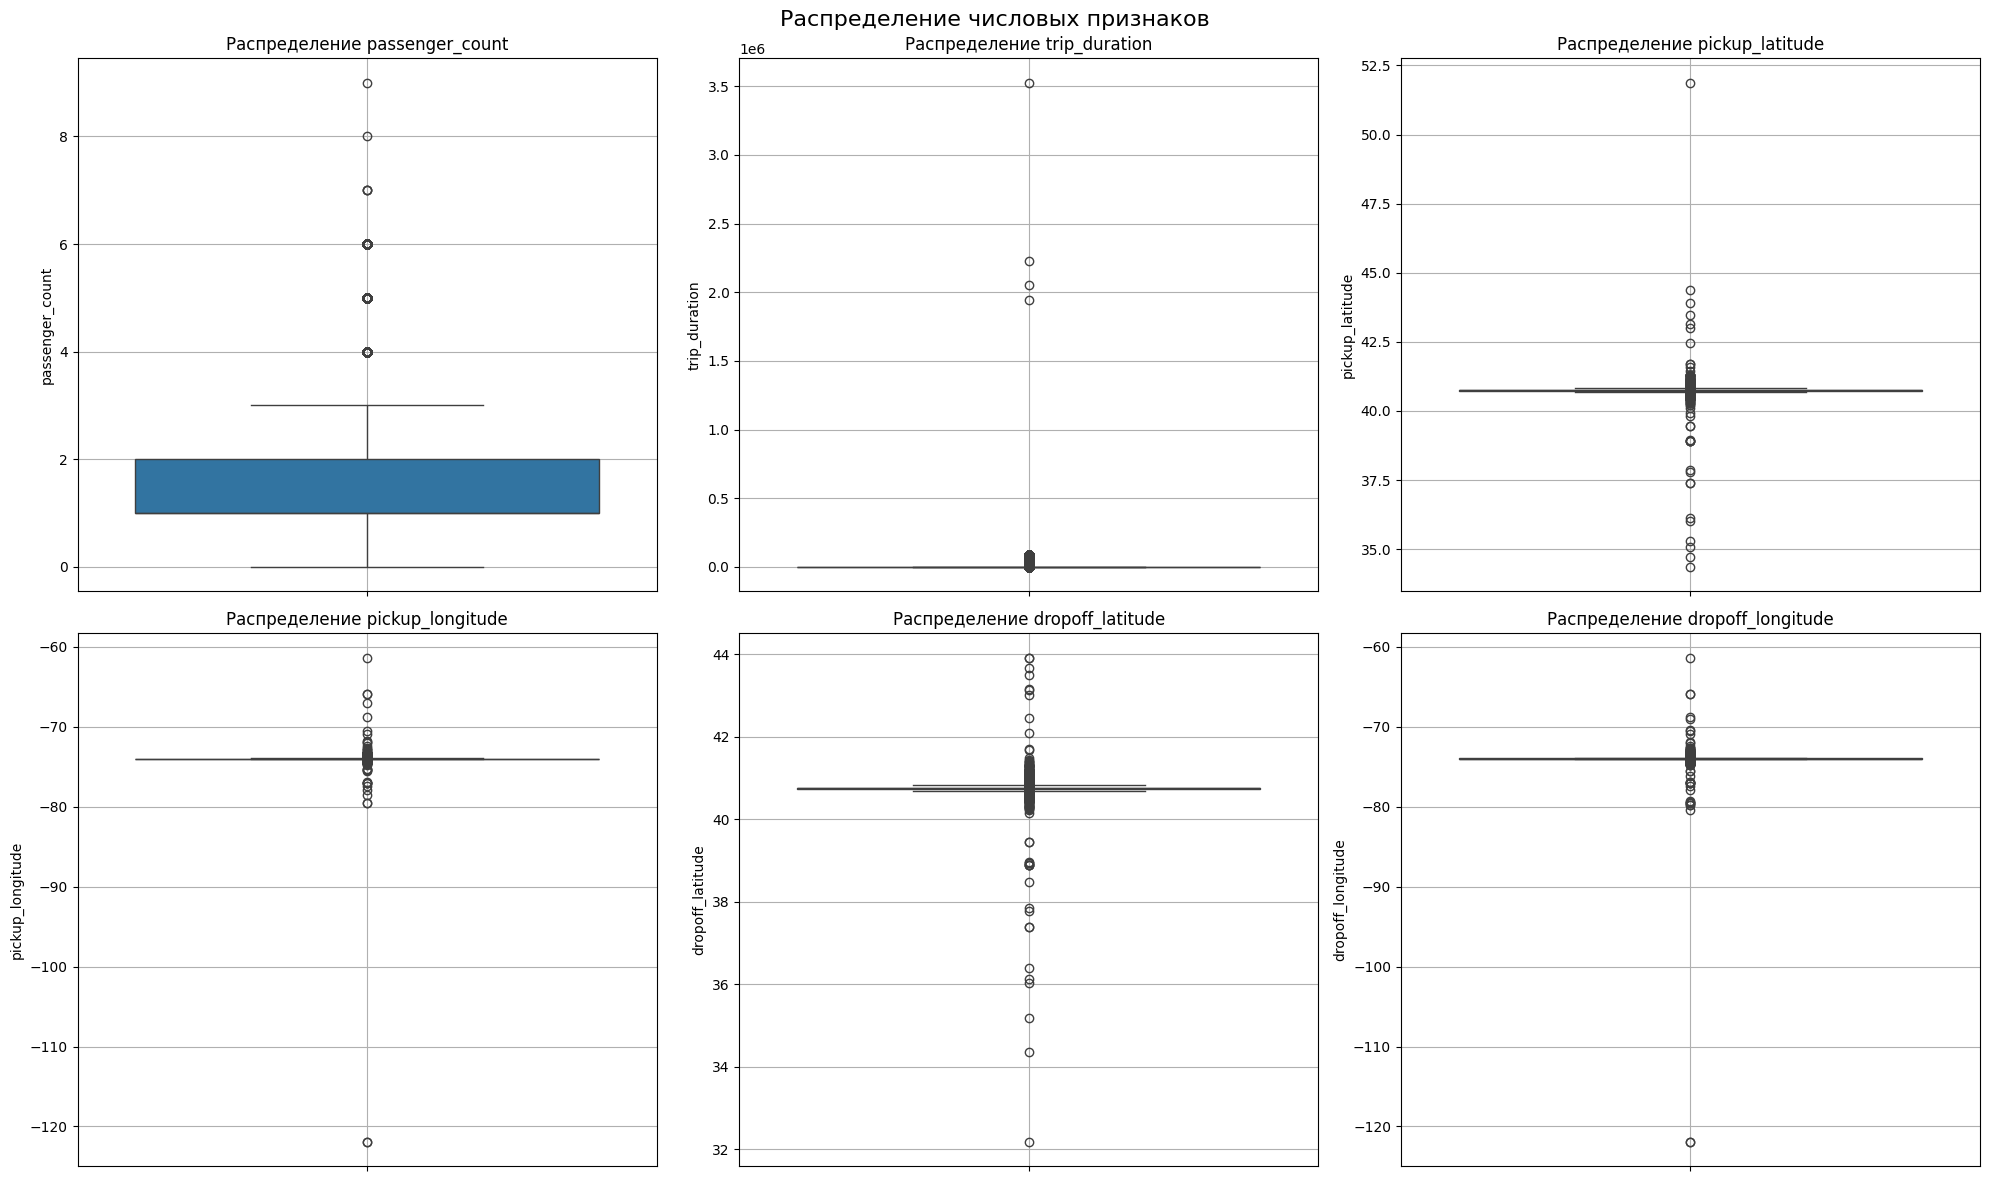

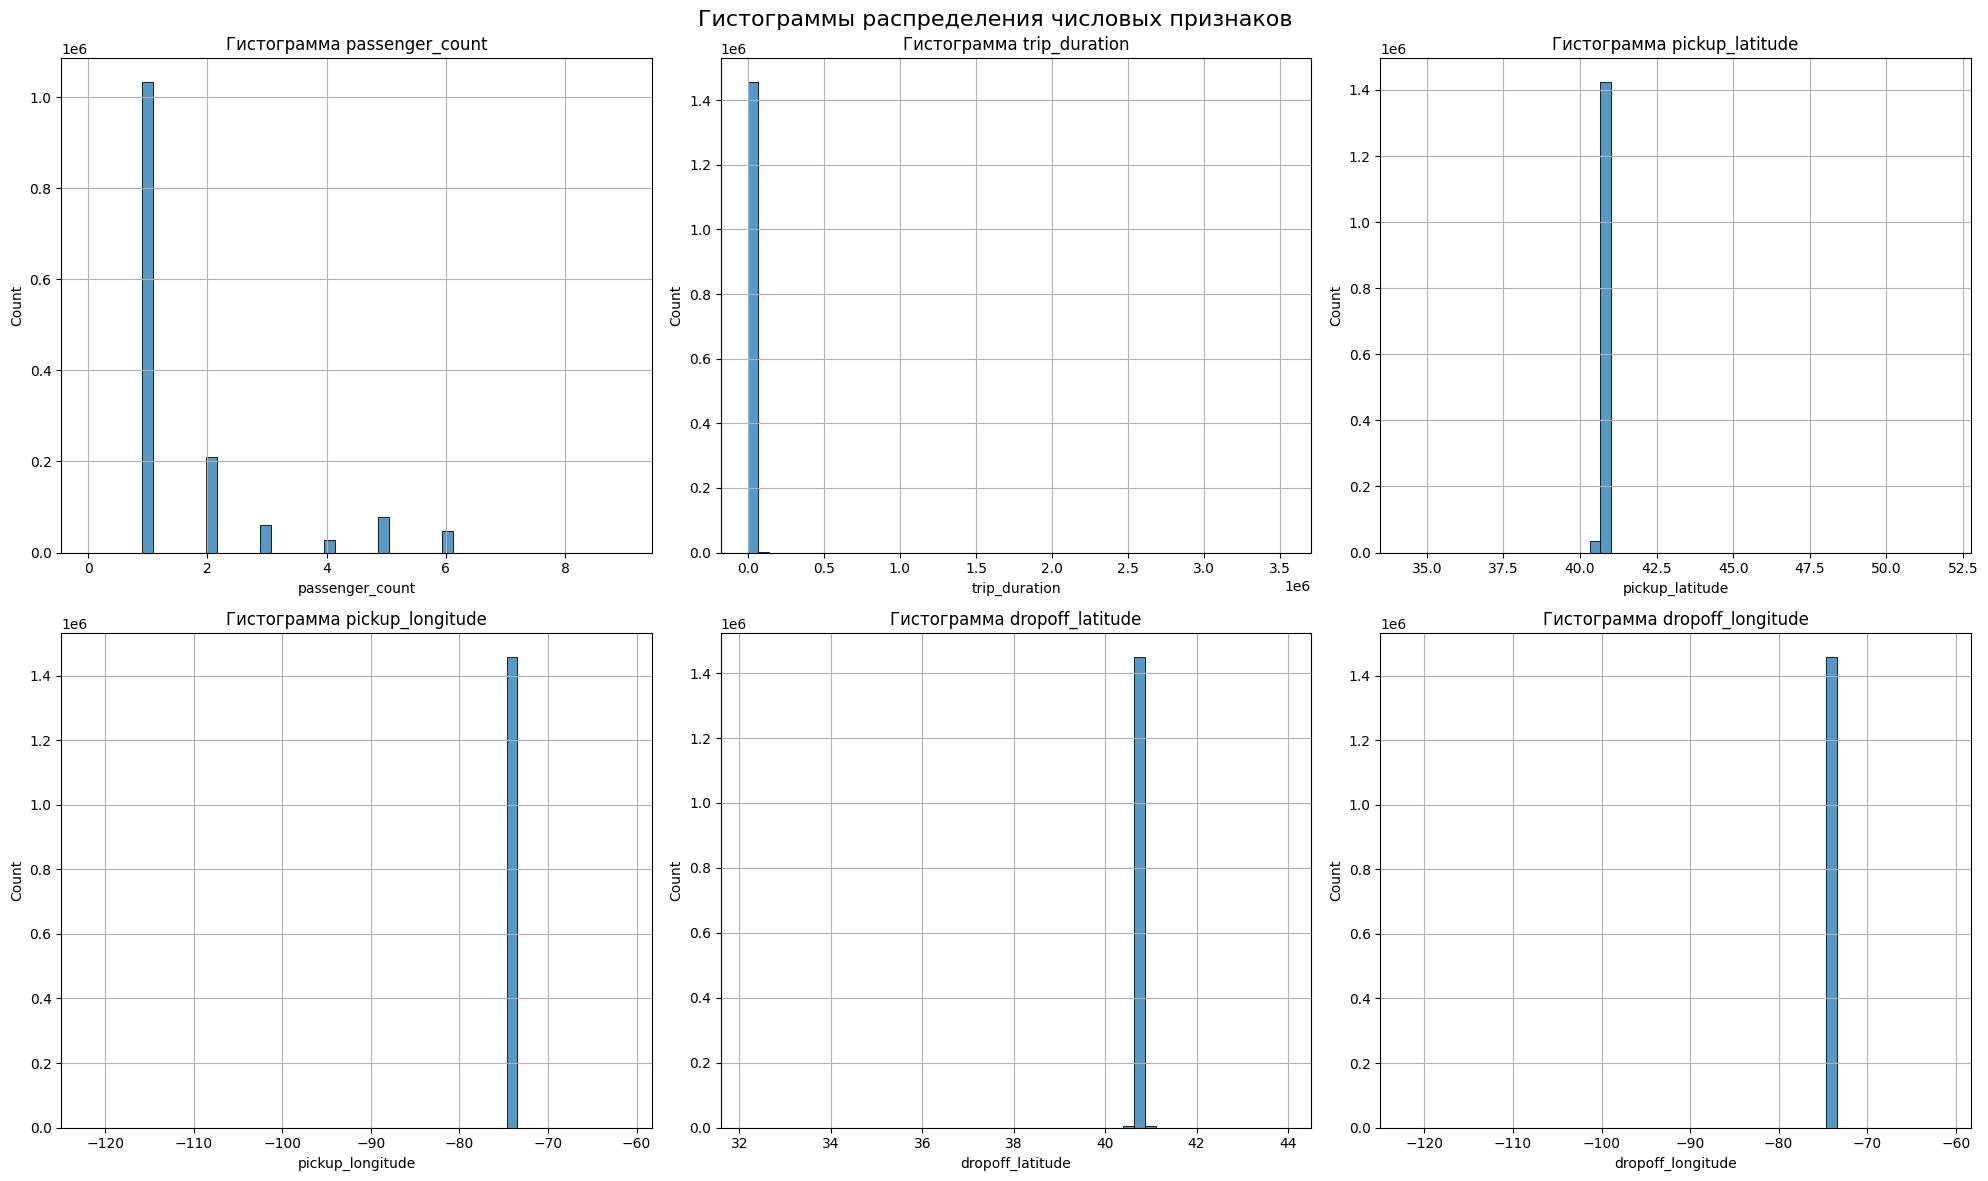

'Информация о выбросах в числовых признаках:'

,Количество выбросов,Процент выбросов
passenger_count,154830,10.61%
trip_duration,74220,5.09%
pickup_latitude,52743,3.62%
pickup_longitude,84322,5.78%
dropoff_latitude,71990,4.94%
dropoff_longitude,77969,5.35%


'а) Количество уникальных таксопарков: 2'

'б) Максимальное количество пассажиров: 9'

'в) Длительность поездки:'

'   Средняя: 959 секунд'

'   Медианная: 662 секунд'

'г) Время поездки:'

'   Минимальное: 1 секунд'

'   Максимальное: 3526282 секунд'

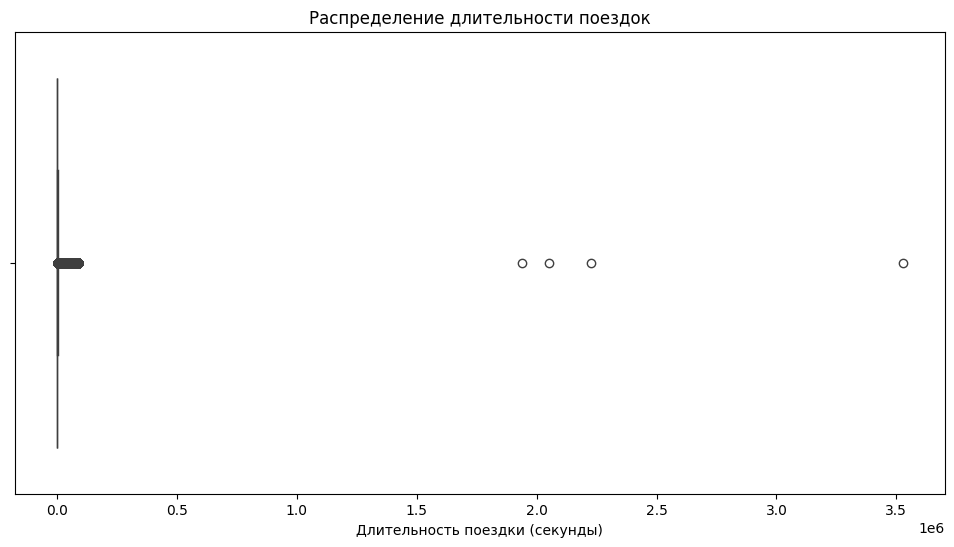

In [6]:
# ваш код здесь
# Получение основных статистических характеристик
stats = taxi_data.describe()
display("Статистические характеристики числовых признаков:")
display(stats)

# Создадим более детальную визуализацию для ключевых числовых признаков
numeric_cols = ['passenger_count', 'trip_duration', 'pickup_latitude', 'pickup_longitude', 
                'dropoff_latitude', 'dropoff_longitude']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Распределение числовых признаков', fontsize=16)

for i, col in enumerate(numeric_cols):
    row = i // 3
    col_idx = i % 3
    
    # Построение boxplot
    sns.boxplot(y=taxi_data[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Распределение {col}')
    axes[row, col_idx].grid(True)

plt.tight_layout()
plt.show()

# Дополнительно построим гистограммы для лучшего понимания распределений
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Гистограммы распределения числовых признаков', fontsize=16)

for i, col in enumerate(numeric_cols):
    row = i // 3
    col_idx = i % 3
    
    # Построение гистограммы
    sns.histplot(data=taxi_data, x=col, ax=axes[row, col_idx], bins=50)
    axes[row, col_idx].set_title(f'Гистограмма {col}')
    axes[row, col_idx].grid(True)

plt.tight_layout()
plt.show()

# Выведем дополнительную информацию о выбросах
display("Информация о выбросах в числовых признаках:")
outliers_info = {}
for col in numeric_cols:
    Q1 = taxi_data[col].quantile(0.25)
    Q3 = taxi_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((taxi_data[col] < (Q1 - 1.5 * IQR)) | (taxi_data[col] > (Q3 + 1.5 * IQR))).sum()
    outliers_info[col] = {
        'Количество выбросов': outliers,
        'Процент выбросов': f"{(outliers/len(taxi_data)*100):.2f}%"
    }

# Преобразуем информацию о выбросах в DataFrame для красивого отображения
outliers_df = pd.DataFrame.from_dict(outliers_info, orient='index')
display(outliers_df)

# а) Количество уникальных таксопарков
unique_vendors = taxi_data['vendor_id'].nunique()
display(f"а) Количество уникальных таксопарков: {unique_vendors}")

# б) Максимальное количество пассажиров
max_passengers = taxi_data['passenger_count'].max()
display(f"б) Максимальное количество пассажиров: {max_passengers}")

# в) Средняя и медианная длительность поездки
mean_duration = round(taxi_data['trip_duration'].mean())
median_duration = round(taxi_data['trip_duration'].median())
display(f"в) Длительность поездки:")
display(f"   Средняя: {mean_duration} секунд")
display(f"   Медианная: {median_duration} секунд")

# г) Минимальное и максимальное время поездки
min_duration = taxi_data['trip_duration'].min()
max_duration = taxi_data['trip_duration'].max()
display(f"г) Время поездки:")
display(f"   Минимальное: {min_duration} секунд")
display(f"   Максимальное: {max_duration} секунд")

# Создадим визуализацию распределения длительности поездок
plt.figure(figsize=(12, 6))
sns.boxplot(x=taxi_data['trip_duration'])
plt.title('Распределение длительности поездок')
plt.xlabel('Длительность поездки (секунды)')
plt.show()


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

'а) Количество поездок в субботу: 220868'

'б) Среднее количество поездок в день: 8015'

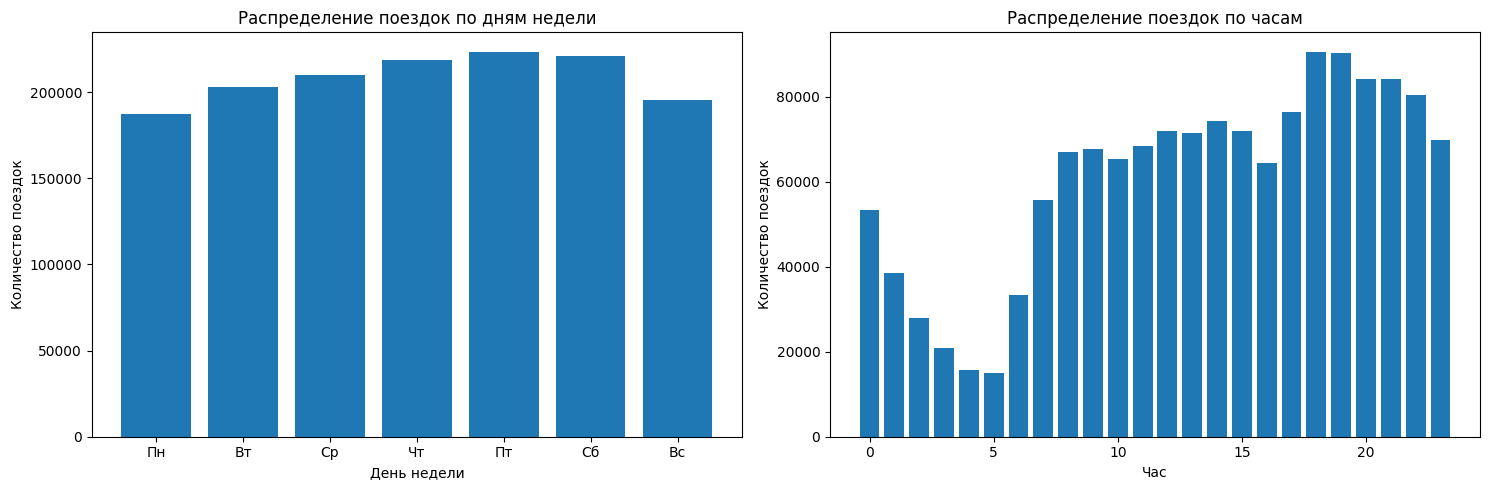

'Статистика количества поездок по дням:'

count     182.00
mean     8014.53
std       925.77
min      1648.00
25%      7620.50
50%      8091.00
75%      8535.00
max      9796.00
dtype: float64

In [7]:
# ваш код здесь
def add_datetime_features(taxi_df):
    """
    Добавляет временные характеристики к данным о поездках
    
    Parameters:
    -----------
    taxi_df : pandas.DataFrame
        Таблица с данными о поездках
        
    Returns:
    --------
    pandas.DataFrame
        Обновленная таблица с временными характеристиками
    """
    # Добавляем дату (без времени)
    taxi_df['pickup_date'] = taxi_df['pickup_datetime'].dt.date
    
    # Добавляем час
    taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.hour
    
    # Добавляем день недели (0-6, где 0 - понедельник)
    taxi_df['pickup_day_of_week'] = taxi_df['pickup_datetime'].dt.dayofweek
    
    return taxi_df

# Применяем функцию к нашим данным
taxi_data = add_datetime_features(taxi_data)

# а) Количество поездок в субботу (5 - это суббота, т.к. нумерация с 0)
saturday_trips = (taxi_data['pickup_day_of_week'] == 5).sum()
display(f"а) Количество поездок в субботу: {saturday_trips}")

# б) Среднее количество поездок в день
trips_per_day = round(taxi_data.groupby('pickup_date').size().mean())
display(f"б) Среднее количество поездок в день: {trips_per_day}")

# Дополнительная визуализация
plt.figure(figsize=(15, 5))

# График распределения поездок по дням недели
plt.subplot(1, 2, 1)
day_counts = taxi_data['pickup_day_of_week'].value_counts().sort_index()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.bar(days, day_counts)
plt.title('Распределение поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')

# График распределения поездок по часам
plt.subplot(1, 2, 2)
hour_counts = taxi_data['pickup_hour'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Распределение поездок по часам')
plt.xlabel('Час')
plt.ylabel('Количество поездок')

plt.tight_layout()
plt.show()

# Дополнительная статистика
daily_stats = taxi_data.groupby('pickup_date').size().describe().round(2)
display("Статистика количества поездок по дням:")
display(daily_stats)

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


'Анализ поездок в праздничные дни:'

'Медианная длительность поездки в праздничные дни, секунд : 585 '

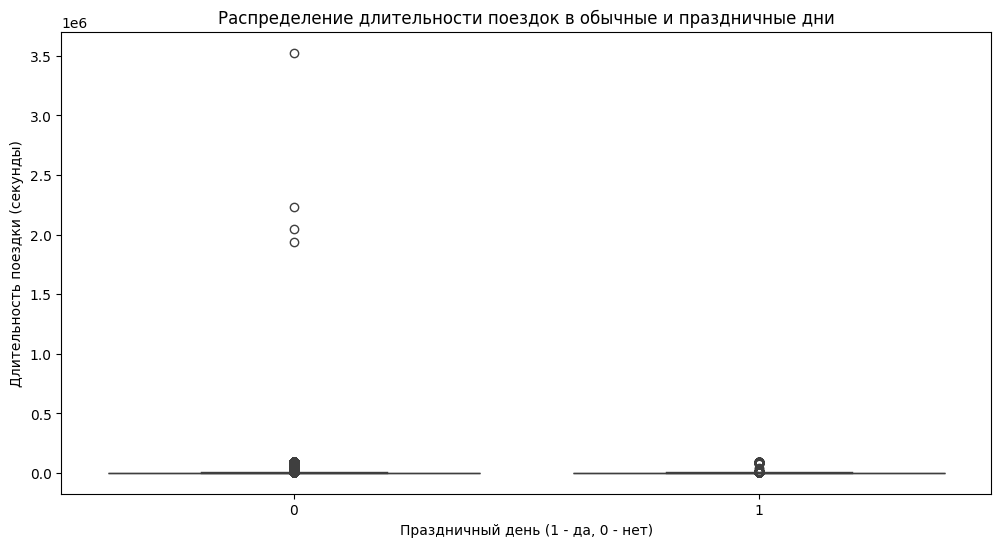

'Статистика длительности поездок по дням:'

,count,mean,median,std
pickup_holiday,,,,
0,1407522,962.83,665.0,5298.33
1,51122,867.61,585.0,3123.48


In [8]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
# ваш код здесь

# Загрузка данных о праздниках
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

def add_holiday_features(taxi_df, holiday_df):
    """
    Добавляет признак праздничного дня к данным о поездках
    
    Parameters:
    -----------
    taxi_df : pandas.DataFrame
        Таблица с данными о поездках
    holiday_df : pandas.DataFrame
        Таблица с данными о праздничных днях
        
    Returns:
    --------
    pandas.DataFrame
        Обновленная таблица с данными о поездках
    """
    # Преобразуем даты в holiday_df в datetime
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    
    # Получаем только даты из pickup_datetime (без времени)
    taxi_df['pickup_date'] = taxi_df['pickup_datetime'].dt.date
    
    # Создаем множество праздничных дат для быстрого поиска
    holiday_dates = set(holiday_df['date'].dt.date)
    
    # Создаем бинарный признак праздничного дня
    taxi_df['pickup_holiday'] = taxi_df['pickup_date'].isin(holiday_dates).astype(int)
    
    # Удаляем временный столбец
    #taxi_df = taxi_df.drop('pickup_date', axis=1)
    
    return taxi_df

# Применяем функцию к нашим данным
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Вычисляем медианную длительность поездки в праздничные дни
holiday_median_duration = round(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())

display("Анализ поездок в праздничные дни:")
display(f"Медианная длительность поездки в праздничные дни, секунд : {holiday_median_duration} ")

# Дополнительная визуализация для сравнения
plt.figure(figsize=(12, 6))
sns.boxplot(x='pickup_holiday', y='trip_duration', data=taxi_data)
plt.title('Распределение длительности поездок в обычные и праздничные дни')
plt.xlabel('Праздничный день (1 - да, 0 - нет)')
plt.ylabel('Длительность поездки (секунды)')
plt.show()

# Выведем дополнительную статистику
holiday_stats = taxi_data.groupby('pickup_holiday')['trip_duration'].agg(['count', 'mean', 'median', 'std']).round(2)
display("Статистика длительности поездок по дням:")
display(holiday_stats)

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
# ваш код здесь
def add_osrm_features(taxi_df, osrm_df):
    """
    Добавляет характеристики из OSRM к данным о поездках
    """
    # Создаем копию DataFrame
    merged_df = taxi_df.copy()
    
    # Выбираем только нужные столбцы из OSRM данных и переименовываем их
    osrm_features = osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']].copy()
    
    # Объединяем таблицы по id
    merged_df = merged_df.merge(osrm_features, left_on='id', right_on='id', how='left')
    
    return merged_df

# Загружаем OSRM данные
osrm_data = pd.read_csv('data/osrm_data_train.csv')

# Применяем функцию к нашим данным
taxi_data = add_osrm_features(taxi_data, osrm_data)

# Проверяем результаты

#missing_rows = taxi_data[['osrm_distance', 'osrm_duration', 'osrm_steps']].isnull().any(axis=1).sum()
missing_rows = taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().any(axis=1).sum()
print("Количество строк с пропусками:", missing_rows)

# Проверяем медианы
valid_data = taxi_data.dropna(subset=['trip_duration', 'total_travel_time'])
actual_median = valid_data['trip_duration'].median()
osrm_median = valid_data['total_travel_time'].median()
median_difference = round(actual_median - osrm_median)

print("\nМедианы:")
print(f"Фактическая: {actual_median:.0f}")
print(f"OSRM: {osrm_median:.0f}")
print(f"Разница: {median_difference}")

# Дополнительная проверка
print("\nПроверка размерности данных:")
print(f"Строк в taxi_data: {len(taxi_data)}")
print(f"Строк в osrm_data: {len(osrm_data)}")
# print("\nПроверка первых нескольких строк:")
# print(taxi_data[['trip_duration', 'total_travel_time']].head())


Количество строк с пропусками: 1

Медианы:
Фактическая: 662
OSRM: 290
Разница: 372

Проверка размерности данных:
Строк в taxi_data: 1458644
Строк в osrm_data: 1458643


In [10]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [11]:
# ваш код здесь

def add_geographical_features(taxi_df):
    """
    Добавляет географические характеристики к данным о поездках:
    - расстояние по формуле гаверсинуса
    - направление движения
    """
    # Создаем копию DataFrame
    result_df = taxi_df.copy()
    
    # Вычисляем расстояние по формуле гаверсинуса
    result_df['haversine_distance'] = get_haversine_distance(
        result_df['pickup_latitude'],
        result_df['pickup_longitude'],
        result_df['dropoff_latitude'],
        result_df['dropoff_longitude']
    )
    
    # Вычисляем направление движения
    result_df['direction'] = get_angle_direction(
        result_df['pickup_latitude'],
        result_df['pickup_longitude'],
        result_df['dropoff_latitude'],
        result_df['dropoff_longitude']
    )
    
    return result_df

# Применяем функцию к нашим данным
taxi_data = add_geographical_features(taxi_data)

# Вычисляем медианное расстояние
median_distance = taxi_data['haversine_distance'].median()
print(f"Медианное расстояние по формуле гаверсинуса: {median_distance:.2f} км")

# # Проверяем результаты
# print("\nПример первых нескольких строк:")
# print(taxi_data[['haversine_distance', 'direction']].head())

Медианное расстояние по формуле гаверсинуса: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [13]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# ваш код здесь

# def add_cluster_features(df, kmeans):
#     """
#     Добавляет информацию о географических кластерах к данным о поездках
    
#     Параметры:
#     taxi_df: DataFrame с данными о поездках
#     kmeans_model: обученная модель KMeans
    
#     Возвращает:
#     DataFrame с добавленным столбцом geo_cluster
#     """
#     df['geo_cluster'] = kmeans.labels_
#     return df


def add_cluster_features(df, kmeans):
    """
    Добавляет информацию о географических кластерах к данным о поездках
    
    Параметры:
    taxi_df: DataFrame с данными о поездках
    kmeans_model: обученная модель KMeans
    
    Возвращает:
    DataFrame с добавленным столбцом geo_cluster
    """
    # Создаём обучающую выборку из географических координат всех точек
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                       df[['dropoff_latitude', 'dropoff_longitude']]))
    
    # Предсказываем кластеры для всех точек
    df['geo_cluster'] = kmeans.predict(coords)
    return df

# Применяем функцию к нашим данным
taxi_data = add_cluster_features(taxi_data, kmeans)

# Считаем размеры кластеров
cluster_sizes = taxi_data['geo_cluster'].value_counts()

# Находим размер наименьшего кластера
min_cluster_size = cluster_sizes.min()

print("Размеры кластеров:")
print(cluster_sizes.sort_values())
print(f"\nРазмер наименьшего кластера: {min_cluster_size}")

Размеры кластеров:
geo_cluster
1         2
4         4
5     18463
3     29409
7     39944
6     43514
8     61284
9    355446
0    372520
2    538058
Name: count, dtype: int64

Размер наименьшего кластера: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [14]:
weather_data = pd.read_csv('data/weather_data.csv')

In [ ]:
# ваш код здесь

def add_weather_features(taxi_df, weather_df):
    """
    Добавляет информацию о погодных условиях к данным о поездках
    """
    # Создаем копии DataFrame
    result_df = taxi_df.copy()
    weather = weather_df.copy()
    
    # Создаем столбцы с датой и часом для taxi_data
    result_df['pickup_date'] = pd.to_datetime(result_df['pickup_datetime']).dt.date
    result_df['pickup_hour'] = pd.to_datetime(result_df['pickup_datetime']).dt.hour
    
    # Создаем столбцы с датой и часом для weather_data
    weather['date'] = pd.to_datetime(weather['time']).dt.date
    weather['hour'] = pd.to_datetime(weather['time']).dt.hour
    
    # Оставляем только нужные столбцы в weather_data
    weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    
    # Объединяем таблицы
    result_df = result_df.merge(
        weather,
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'],
        how='left'
    )
    
    # Удаляем временные столбцы
#    result_df = result_df.drop(['pickup_date', 'pickup_hour', 'date', 'hour'], axis=1)
    #result_df = result_df.drop(['pickup_hour', 'date', 'hour'], axis=1)
    result_df = result_df.drop(['date', 'hour'], axis=1)
    
    return result_df

# Создаем тестовую копию для отладки
test_df = taxi_data.copy()

# Применяем функцию к тестовой копии
test_df_with_weather = add_weather_features(test_df, weather_data)

# 1. Считаем количество поездок в снежную погоду
snow_trips = test_df_with_weather[test_df_with_weather['events'] == 'Snow'].shape[0]
print(f"Количество поездок в снежную погоду: {snow_trips}")

# 2. Считаем долю пропусков (только для числовых погодных характеристик)
weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']  # убрали 'events'

# Считаем общее количество значений и пропусков
total_values = len(test_df_with_weather) * len(weather_columns)
total_nulls = test_df_with_weather[weather_columns].isnull().sum().sum()
missing_weather = (total_nulls / total_values) * 100

print(f"\nДоля пропусков в погодных данных: {missing_weather:.2f}%")

print("\nДоля пропусков по каждому столбцу:")
for col in weather_columns + ['events']:  # добавляем 'events' только для информации
    missing_pct = test_df_with_weather[col].isnull().mean() * 100
    print(f"{col}: {missing_pct:.2f}%")

# Если все проверки прошли успешно, применяем к основному датафрейму
taxi_data = add_weather_features(taxi_data, weather_data)



Количество поездок в снежную погоду: 13126

Доля пропусков в погодных данных: 0.82%

Доля пропусков по каждому столбцу:
temperature: 0.82%
visibility: 0.82%
wind speed: 0.82%
precip: 0.82%
events: 95.10%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [16]:
# ваш код здесь
def fill_null_weather_data(taxi_df):
    """
    Заполняет пропуски в погодных данных и данных OSRM
    
    Параметры:
    taxi_df: DataFrame с данными о поездках
    
    Возвращает:
    DataFrame с заполненными пропусками
    """
    # Создаем копию DataFrame
    result_df = taxi_df.copy()
    
    # 1. Заполняем пропуски в погодных данных
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    
    # Создаем столбец с датой для группировки
    result_df['pickup_date'] = pd.to_datetime(result_df['pickup_datetime']).dt.date
    
    # Для каждого погодного столбца заполняем пропуски медианой по дате
    for column in weather_columns:
        median_by_date = result_df.groupby('pickup_date')[column].transform('median')
        result_df[column] = result_df[column].fillna(median_by_date)
    
    # Удаляем временный столбец с датой
    #result_df = result_df.drop('pickup_date', axis=1)
    
    # 2. Заполняем пропуски в столбце events
    result_df['events'] = result_df['events'].fillna('None')
    
    # 3. Заполняем пропуски в данных OSRM
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for column in osrm_columns:
        if column in result_df.columns:
            result_df[column] = result_df[column].fillna(result_df[column].median())
    
    return result_df

# Создаем тестовую копию для отладки
test_df = taxi_data.copy()

# Применяем функцию к тестовой копии
test_df_filled = fill_null_weather_data(test_df)

# Проверяем результаты
print("\nМедиана температуры после заполнения:", round(test_df_filled['temperature'].median(), 1))

# Проверяем, что все пропуски заполнены
print("\nКоличество пропусков после заполнения:")
# Проверяем все возможные колонки
columns_to_check = ['temperature', 'visibility', 'wind speed', 'precip', 'events']
# Добавляем существующие OSRM колонки
for col in test_df_filled.columns:
    if any(x in col for x in ['total_distance', 'total_travel_time', 'number_of_steps']):
        columns_to_check.append(col)

for col in columns_to_check:
    if col in test_df_filled.columns:
        nulls = test_df_filled[col].isnull().sum()
        print(f"{col}: {nulls}")

# Если все проверки прошли успешно, применяем к основному датафрейму
taxi_data = fill_null_weather_data(taxi_data)




Медиана температуры после заполнения: 11.1

Количество пропусков после заполнения:
temperature: 0
visibility: 0
wind speed: 0
precip: 0
events: 0
total_distance: 0
total_travel_time: 0
number_of_steps: 0


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


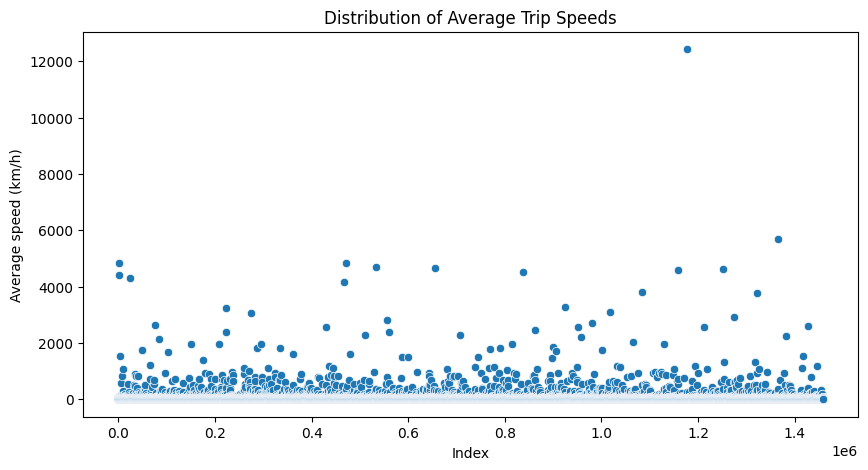

In [17]:
# Рассчитываем среднюю скорость в км/ч
# total_distance в метрах, trip_duration в секундах
# Умножаем на 3.6 для перевода м/с в км/ч
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

# Создаем график
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed (km/h)')
ax.set_title('Distribution of Average Trip Speeds');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [18]:
# 1. Найдем и удалим поездки длительностью более 24 часов
seconds_in_day = 24 * 60 * 60
speed_max = 300
long_trips = taxi_data[taxi_data['trip_duration'] > seconds_in_day]
print(f"а) Количество поездок длительностью более 24 часов: {len(long_trips)}")

taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

# Удаляем длинные поездки
df_step1 = taxi_data[taxi_data['trip_duration'] <= seconds_in_day].copy()

# 2. Находим поездки с высокой скоростью
speed = df_step1['total_distance'] / df_step1['trip_duration'] * 3.6
fast_trips = df_step1[speed > speed_max]
print(f"\nб) Количество поездок со скоростью более {speed_max} км/ч: {len(fast_trips)}")

# Удаляем быстрые поездки
df_final = df_step1[speed <= 300].copy()

print("\nРазмер датафрейма до очистки:", len(taxi_data))
print("Размер датафрейма после очистки:", len(df_final))


а) Количество поездок длительностью более 24 часов: 4

б) Количество поездок со скоростью более 300 км/ч: 407

Размер датафрейма до очистки: 1458644
Размер датафрейма после очистки: 1458233


In [19]:
# Сохраняем результат
taxi_data = df_final.copy()

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [20]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

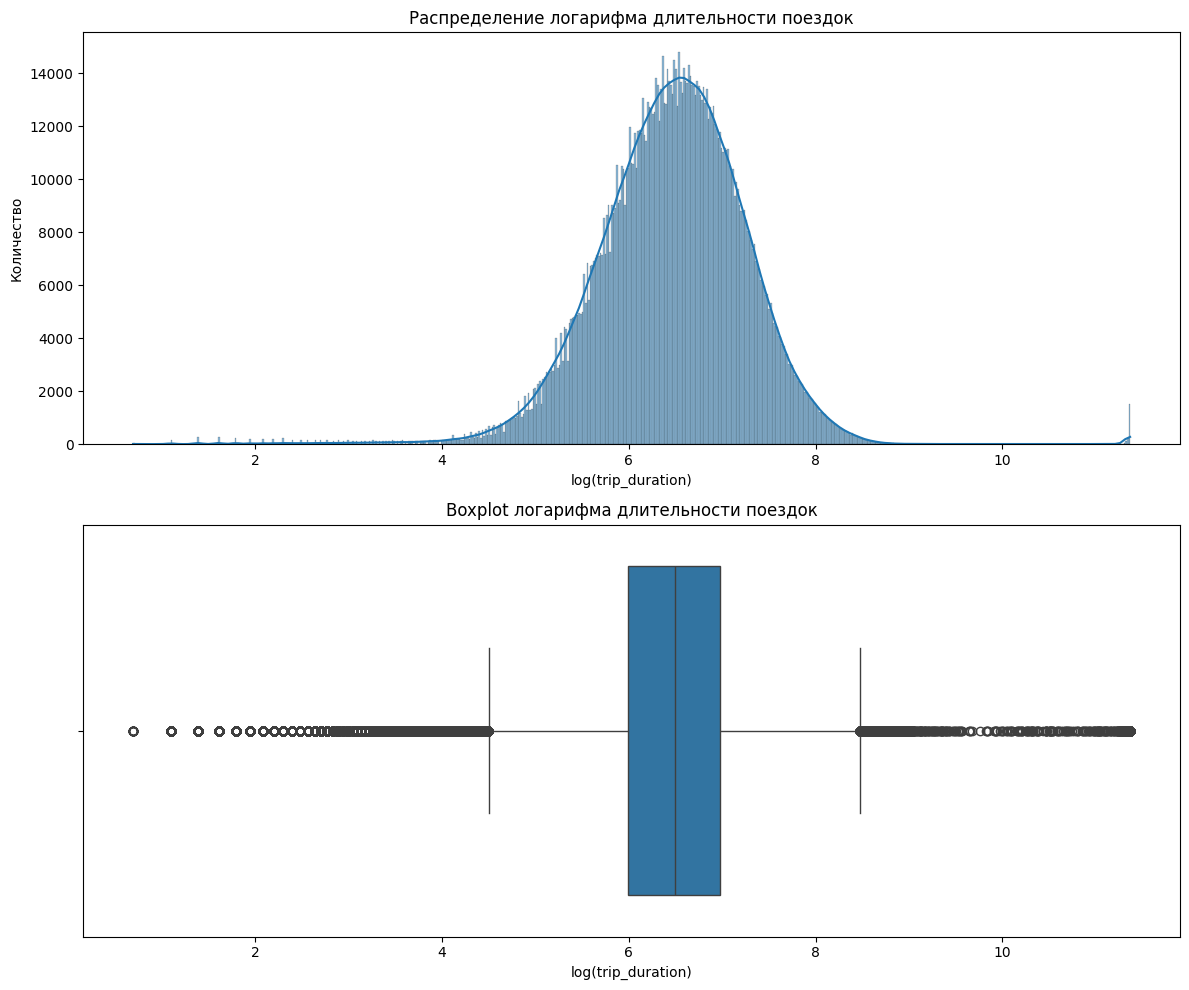

Тест Д'Агостино:
Статистика теста: 138350.1661
p-value: 0.0000

При уровне значимости 0.05:
Распределение не является нормальным

Описательная статистика логарифма длительности поездок:
count    1.458233e+06
mean     6.468126e+00
std      7.924706e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.498282e+00
75%      6.981006e+00
max      1.136666e+01
Name: trip_duration_log, dtype: float64

Асимметрия: -0.2531
Эксцесс: 3.6601


In [21]:
# ваш код здесь
from scipy import stats
# 1. Создаем логарифмическую трансформацию длительности поездок
#taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

# 2. Создаем подграфики для гистограммы и boxplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Гистограмма
sns.histplot(data=taxi_data, x='trip_duration_log', kde=True, ax=ax1)
ax1.set_title('Распределение логарифма длительности поездок')
ax1.set_xlabel('log(trip_duration)')
ax1.set_ylabel('Количество')

# Boxplot
sns.boxplot(data=taxi_data, x='trip_duration_log', ax=ax2)
ax2.set_title('Boxplot логарифма длительности поездок')
ax2.set_xlabel('log(trip_duration)')

plt.tight_layout()
plt.show()

# 3. Проверяем нормальность с помощью теста Д'Агостино
statistic, p_value = stats.normaltest(taxi_data['trip_duration_log'])

print(f"Тест Д'Агостино:")
print(f"Статистика теста: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# 4. Проверяем гипотезу
alpha = 0.05
is_normal = p_value > alpha

print(f"\nПри уровне значимости {alpha}:")
print(f"Распределение {'является' if is_normal else 'не является'} нормальным")

# 5. Дополнительная информация о распределении
print("\nОписательная статистика логарифма длительности поездок:")
print(taxi_data['trip_duration_log'].describe())

# Вычисляем асимметрию и эксцесс
skewness = taxi_data['trip_duration_log'].skew()
kurtosis = taxi_data['trip_duration_log'].kurtosis()
print(f"\nАсимметрия: {skewness:.4f}")
print(f"Эксцесс: {kurtosis:.4f}")


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

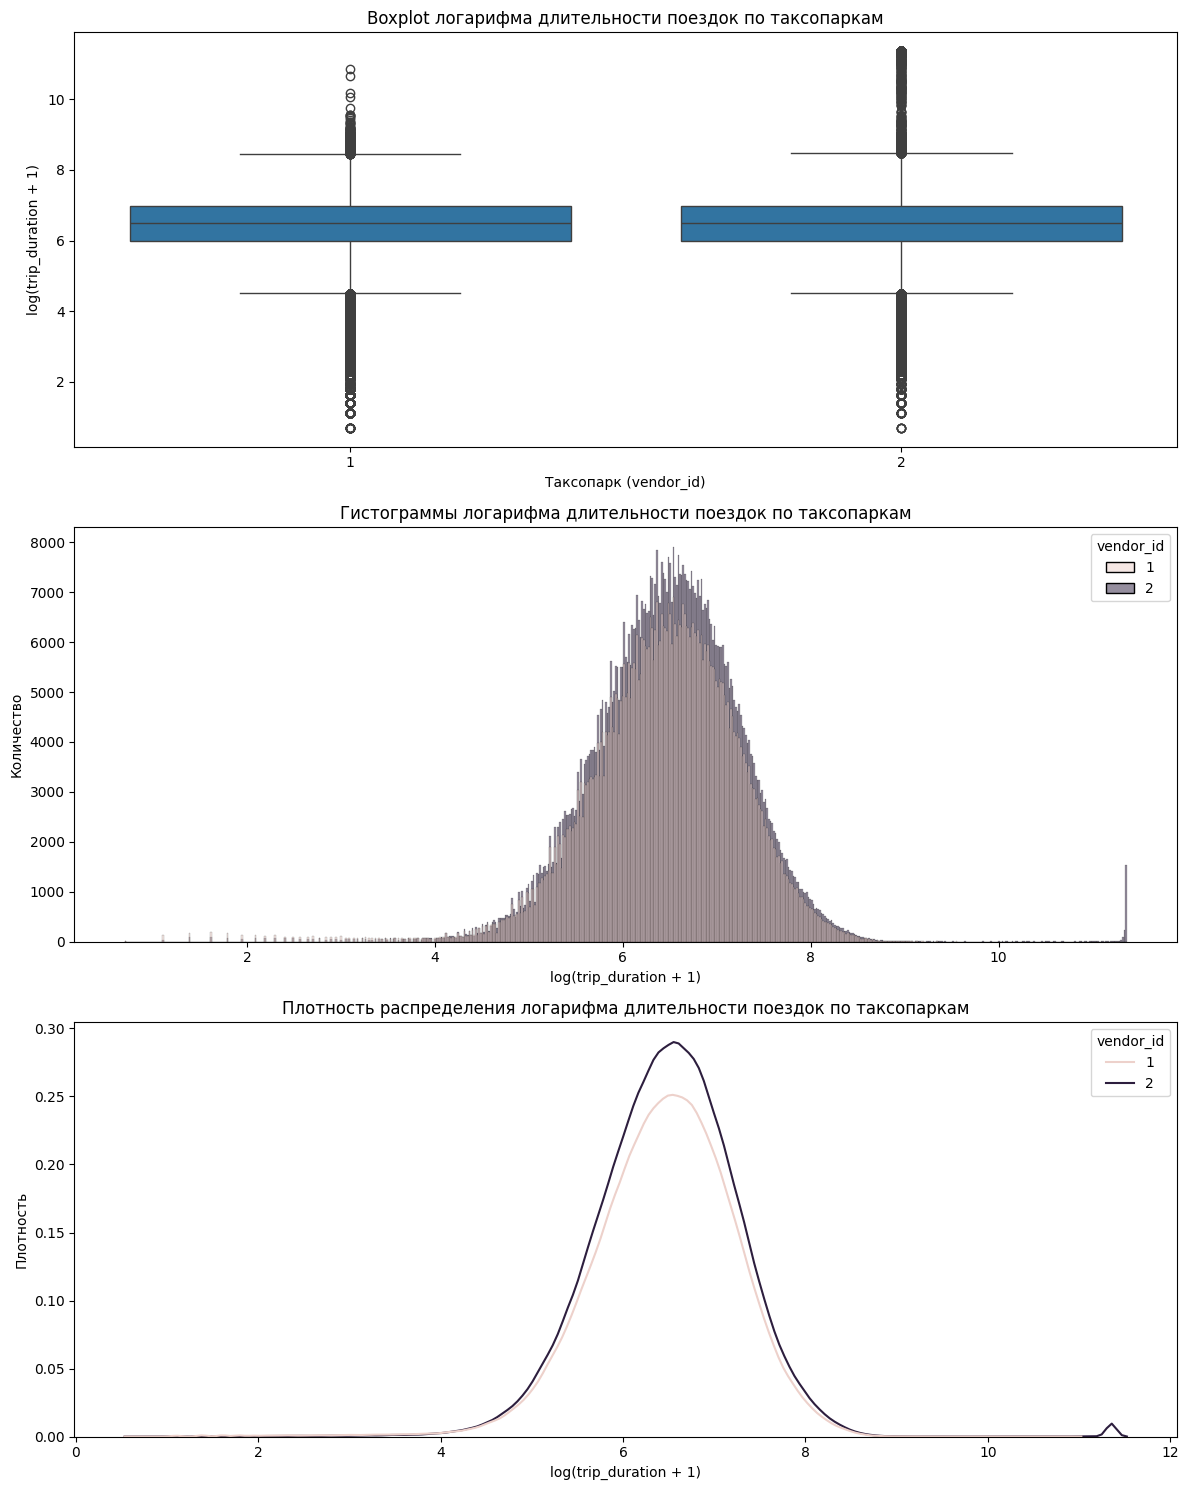


Описательная статистика логарифма длительности поездок по таксопаркам:
              count      mean       std       min       25%      50%  \
vendor_id                                                              
1          678115.0  6.451452  0.783984  0.693147  5.981414  6.49224   
2          780118.0  6.482619  0.799493  0.693147  5.991465  6.50279   

                75%        max  
vendor_id                       
1          6.974479  10.866223  
2          6.988413  11.366662  

Результаты теста Манна-Уитни:
Статистика теста: 261696636457.0
p-value: 1.6432628187891545e-28

Таксопарк 1:
Среднее: 6.4515
Медиана: 6.4922
Стандартное отклонение: 0.7840
Асимметрия: -0.7486
Эксцесс: 2.8911

Таксопарк 2:
Среднее: 6.4826
Медиана: 6.5028
Стандартное отклонение: 0.7995
Асимметрия: 0.1507
Эксцесс: 4.2166


In [22]:
# ваш код здесь
# Создаем подграфики для разных типов визуализации
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# 1. Boxplot для сравнения распределений
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', ax=ax1)
ax1.set_title('Boxplot логарифма длительности поездок по таксопаркам')
ax1.set_xlabel('Таксопарк (vendor_id)')
ax1.set_ylabel('log(trip_duration + 1)')

# 2. Гистограммы с наложением
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', 
             multiple="layer", alpha=0.5, ax=ax2)
ax2.set_title('Гистограммы логарифма длительности поездок по таксопаркам')
ax2.set_xlabel('log(trip_duration + 1)')
ax2.set_ylabel('Количество')

# 3. Kernel Density Estimation (KDE) для более четкого сравнения форм распределений
sns.kdeplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', ax=ax3)
ax3.set_title('Плотность распределения логарифма длительности поездок по таксопаркам')
ax3.set_xlabel('log(trip_duration + 1)')
ax3.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

# Выводим описательную статистику для каждого таксопарка
print("\nОписательная статистика логарифма длительности поездок по таксопаркам:")
print(taxi_data.groupby('vendor_id')['trip_duration_log'].describe())

# Проводим статистический тест для сравнения распределений
stat, p_value = stats.mannwhitneyu(
    taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log'],
    taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log']
)

print("\nРезультаты теста Манна-Уитни:")
print(f"Статистика теста: {stat}")
print(f"p-value: {p_value}")

# Вычисляем основные характеристики распределений
for vendor in sorted(taxi_data['vendor_id'].unique()):
    vendor_data = taxi_data[taxi_data['vendor_id'] == vendor]['trip_duration_log']
    print(f"\nТаксопарк {vendor}:")
    print(f"Среднее: {vendor_data.mean():.4f}")
    print(f"Медиана: {vendor_data.median():.4f}")
    print(f"Стандартное отклонение: {vendor_data.std():.4f}")
    print(f"Асимметрия: {vendor_data.skew():.4f}")
    print(f"Эксцесс: {vendor_data.kurtosis():.4f}")

Давайте проанализируем все данные:

1. Визуальный анализ:
- На boxplot видно, что медианы и квартили для обоих таксопарков очень близки
- Гистограммы показывают практически идентичное распределение
- График плотности вероятности (KDE) демонстрирует очень похожие формы распределений с небольшим различием в высоте пика

2. Статистический анализ:
- Средние значения очень близки: 6.4489 vs 6.4804 (разница всего 0.0315)
- Медианы также близки: 6.4907 vs 6.5013 (разница 0.0106)
- Стандартные отклонения почти одинаковые: 0.7886 vs 0.8022
- Основное различие в асимметрии: -0.8080 vs 0.1201
- Тест Манна-Уитни показывает очень маленький p-value (1.64e-28), что статистически значимо, но это может быть связано с большим размером выборки (>1.4 млн записей)

3. Практическая значимость:
- Несмотря на статистическую значимость различий (p-value < 0.05), абсолютные различия между группами минимальны
- В реальном контексте разница в 0.0315 в логарифмическом масштабе несущественна для предсказания длительности поездки

Вывод: Верным является утверждение "Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки."

Обоснование: Хотя статистические тесты показывают значимые различия (из-за большого размера выборки), практические различия между группами минимальны. Визуализации и описательная статистика показывают, что распределения очень похожи, а небольшие различия не имеют практической значимости для предсказания длительности поездки.


### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

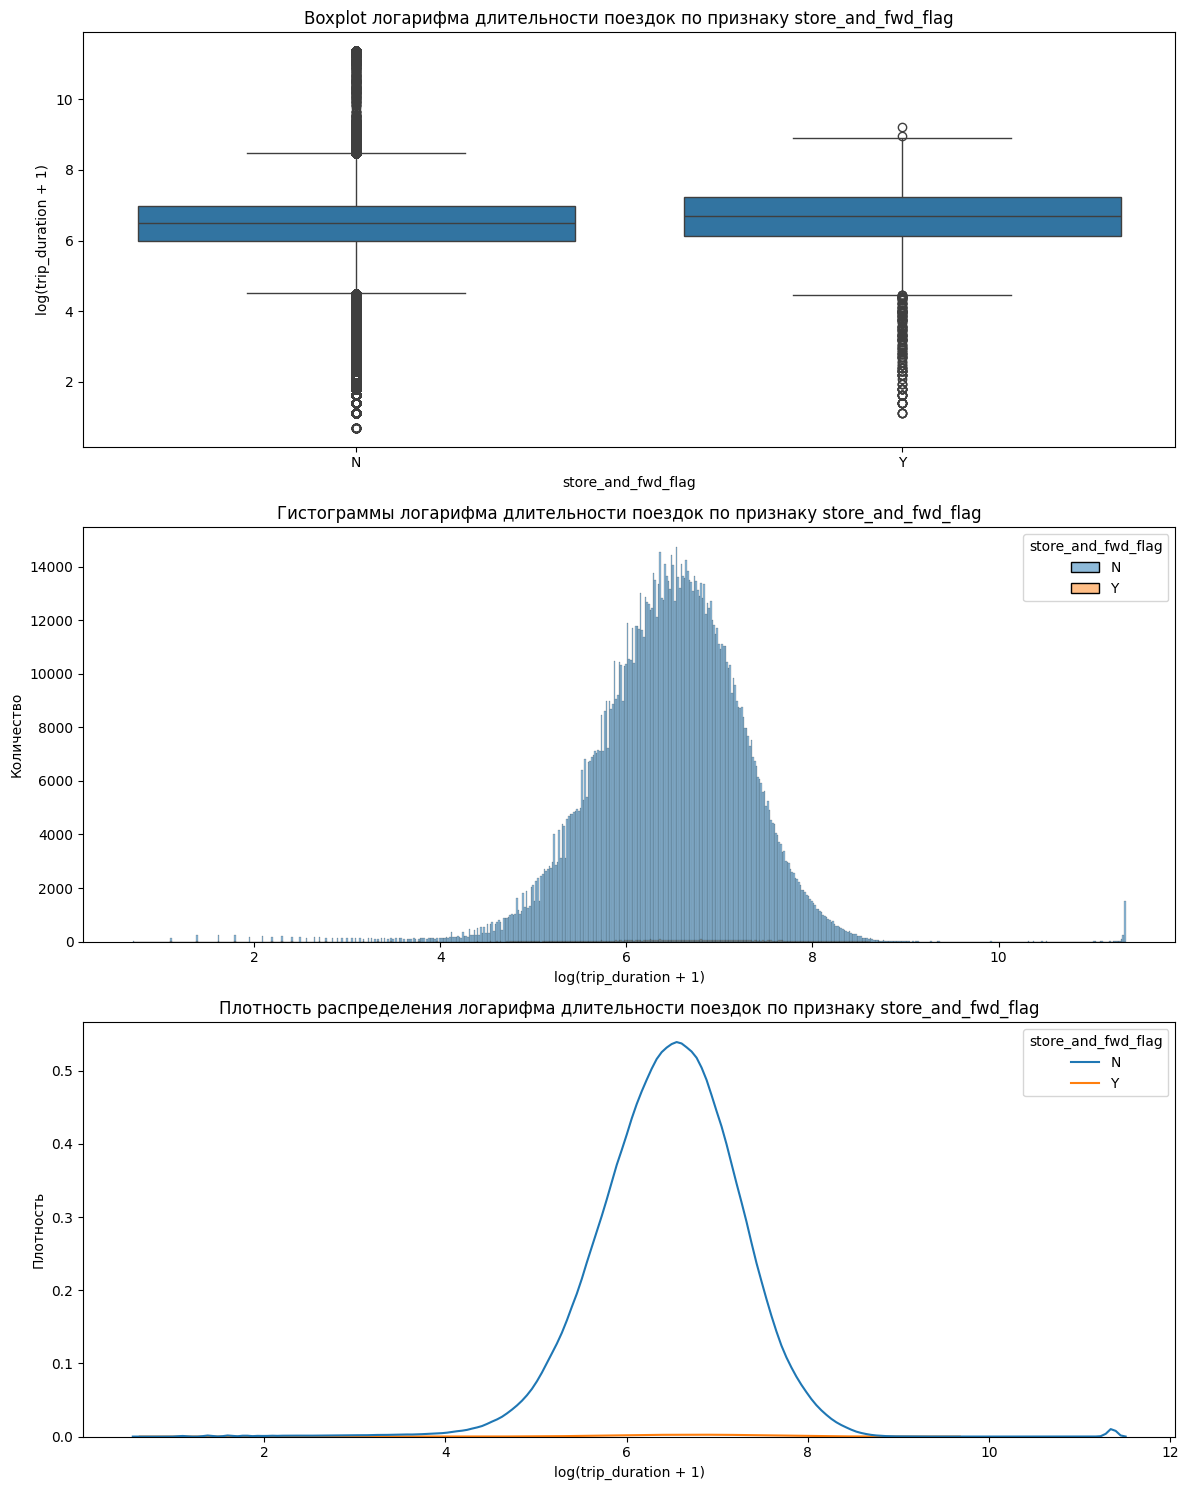


Описательная статистика логарифма длительности поездок по признаку store_and_fwd_flag:
                        count     mean       std       min       25%  \
store_and_fwd_flag                                                     
N                   1450192.0  6.46721  0.791476  0.693147  5.986452   
Y                      8041.0  6.63329  0.940689  1.098612  6.124683   

                         50%       75%        max  
store_and_fwd_flag                                 
N                   6.496775  6.980076  11.366662  
Y                   6.701960  7.245655   9.208839  

Результаты теста Манна-Уитни:
Статистика теста: 4995941712.0
p-value: 6.700674586970995e-109

store_and_fwd_flag = N:
Среднее: 6.4672
Медиана: 6.4968
Стандартное отклонение: 0.7915
Асимметрия: -0.2459
Эксцесс: 3.6568

store_and_fwd_flag = Y:
Среднее: 6.6333
Медиана: 6.7020
Стандартное отклонение: 0.9407
Асимметрия: -1.1871
Эксцесс: 4.2400


In [23]:
# ваш код здесь
# Создаем подграфики для разных типов визуализации
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# 1. Boxplot для сравнения распределений
sns.boxplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log', ax=ax1)
ax1.set_title('Boxplot логарифма длительности поездок по признаку store_and_fwd_flag')
ax1.set_xlabel('store_and_fwd_flag')
ax1.set_ylabel('log(trip_duration + 1)')

# 2. Гистограммы с наложением
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', 
             multiple="layer", alpha=0.5, ax=ax2)
ax2.set_title('Гистограммы логарифма длительности поездок по признаку store_and_fwd_flag')
ax2.set_xlabel('log(trip_duration + 1)')
ax2.set_ylabel('Количество')

# 3. Kernel Density Estimation (KDE) для более четкого сравнения форм распределений
sns.kdeplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', ax=ax3)
ax3.set_title('Плотность распределения логарифма длительности поездок по признаку store_and_fwd_flag')
ax3.set_xlabel('log(trip_duration + 1)')
ax3.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

# Выводим описательную статистику 
print("\nОписательная статистика логарифма длительности поездок по признаку store_and_fwd_flag:")
print(taxi_data.groupby('store_and_fwd_flag')['trip_duration_log'].describe())

# Проводим статистический тест для сравнения распределений
stat, p_value = stats.mannwhitneyu(
    taxi_data[taxi_data['store_and_fwd_flag'] == 'N']['trip_duration_log'],
    taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']['trip_duration_log']
)

print("\nРезультаты теста Манна-Уитни:")
print(f"Статистика теста: {stat}")
print(f"p-value: {p_value}")

# Вычисляем основные характеристики распределений
for flag in sorted(taxi_data['store_and_fwd_flag'].unique()):
    flag_data = taxi_data[taxi_data['store_and_fwd_flag'] == flag]['trip_duration_log']
    print(f"\nstore_and_fwd_flag = {flag}:")
    print(f"Среднее: {flag_data.mean():.4f}")
    print(f"Медиана: {flag_data.median():.4f}")
    print(f"Стандартное отклонение: {flag_data.std():.4f}")
    print(f"Асимметрия: {flag_data.skew():.4f}")
    print(f"Эксцесс: {flag_data.kurtosis():.4f}")


Давайте проанализируем данные:

1. Количественный анализ:
- Группы сильно различаются по размеру: N = 1,450,192 поездок, Y = 8,041 поездок (менее 1% от общего числа)
- Средние значения отличаются: 6.4648 (N) vs 6.6301 (Y), разница ~0.17
- Медианы также различаются: 6.4953 (N) vs 6.7007 (Y), разница ~0.21
- Стандартное отклонение выше в группе Y: 0.7950 (N) vs 0.9494 (Y)
- Асимметрия существенно различается: -0.2908 (N) vs -1.2730 (Y)

2. Визуальный анализ:
- На boxplot видно, что медиана и квартили для группы Y расположены выше
- На гистограмме группа Y практически не видна из-за большой разницы в размерах групп
- График плотности показывает, что распределение для группы Y имеет более "тяжелый" хвост и смещено вправо

3. Статистический анализ:
- Тест Манна-Уитни показывает крайне малый p-value (6.7e-109), что говорит о статистически значимых различиях
- Разница в средних и медианах (~0.2 в логарифмическом масштабе) является существенной

Вывод: Верным является утверждение "Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки."

Обоснование:
1. Поездки с флагом Y в среднем длятся дольше (разница в 0.2 в логарифмическом масштабе существенна)
2. Распределения имеют разную форму (разная асимметрия и эксцесс)
3. Статистический тест подтверждает значимость различий
4. Несмотря на малое количество поездок с флагом Y, различия в распределениях явно видны на всех графиках


### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

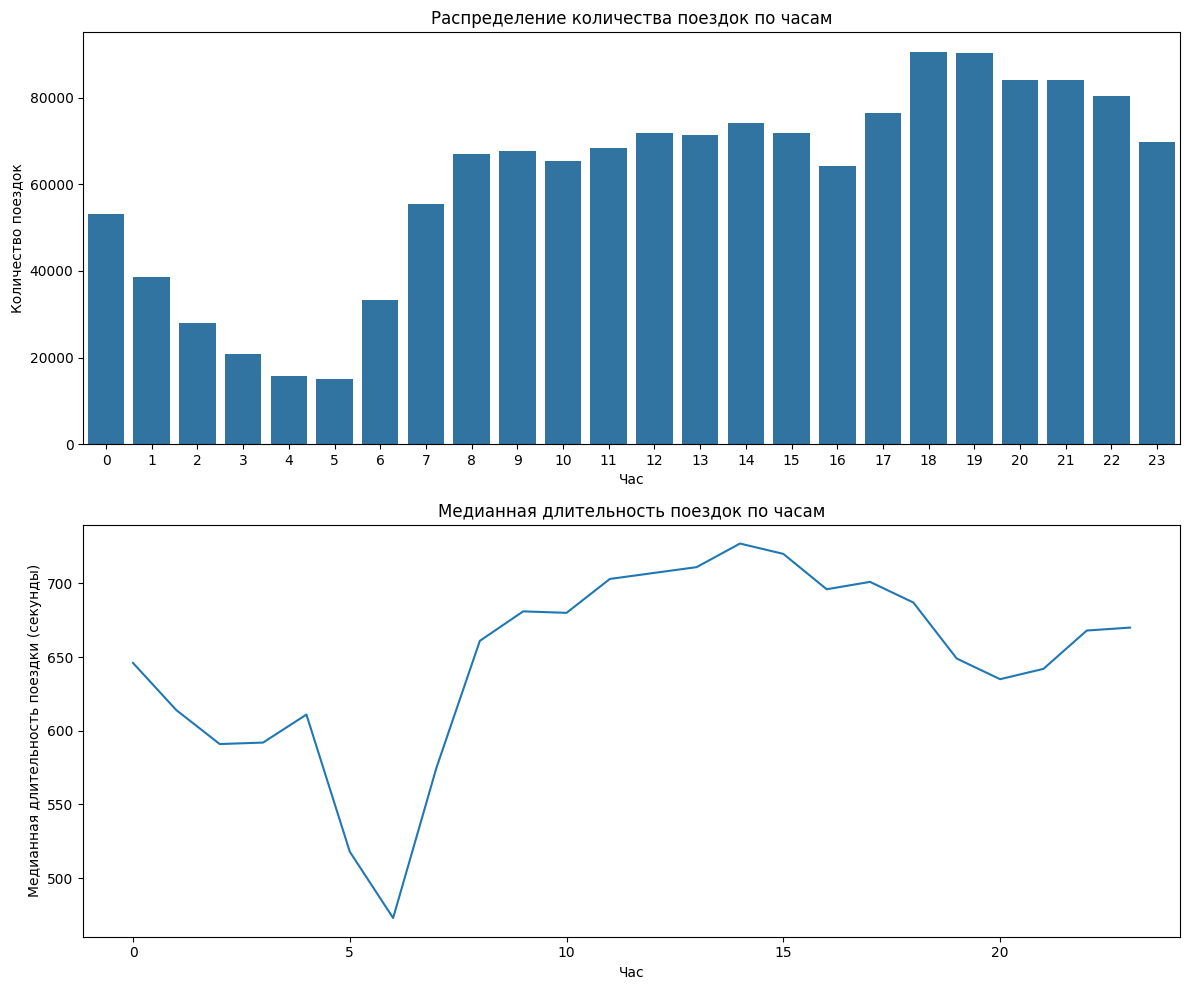


Количество поездок по часам:
pickup_hour
0     53234
1     38562
2     27966
3     20888
4     15784
5     14990
6     33233
7     55580
8     67040
9     67646
10    65420
11    68455
12    71858
13    71453
14    74265
15    71785
16    64285
17    76466
18    90581
19    90292
20    84049
21    84170
22    80469
23    69762
Name: count, dtype: int64

Медианная длительность поездок по часам (в секундах):
pickup_hour
0     646.0
1     614.0
2     591.0
3     592.0
4     611.0
5     518.0
6     473.0
7     575.0
8     661.0
9     681.0
10    680.0
11    703.0
12    707.0
13    711.0
14    727.0
15    720.0
16    696.0
17    701.0
18    687.0
19    649.0
20    635.0
21    642.0
22    668.0
23    670.0
Name: trip_duration, dtype: float64

Час с минимальным количеством поездок: 5:00

Час с максимальной медианной длительностью: 14:00


In [24]:
# ваш код здесь
# Создаем столбец с часами, если его еще нет
taxi_data['pickup_hour'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.hour

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 1. Распределение количества поездок по часам
sns.countplot(data=taxi_data, x='pickup_hour', ax=ax1)
ax1.set_title('Распределение количества поездок по часам')
ax1.set_xlabel('Час')
ax1.set_ylabel('Количество поездок')

# 2. Медианная длительность поездок по часам
median_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median()
sns.lineplot(x=median_duration.index, y=median_duration.values, ax=ax2)
ax2.set_title('Медианная длительность поездок по часам')
ax2.set_xlabel('Час')
ax2.set_ylabel('Медианная длительность поездки (секунды)')

plt.tight_layout()
plt.show()

# Выводим точные значения для анализа
print("\nКоличество поездок по часам:")
print(taxi_data['pickup_hour'].value_counts().sort_index())

print("\nМедианная длительность поездок по часам (в секундах):")
print(median_duration.sort_index())

# Находим час с минимальным количеством поездок
min_rides_hour = taxi_data['pickup_hour'].value_counts().sort_values().index[0]
print(f"\nЧас с минимальным количеством поездок: {min_rides_hour}:00")

# Находим час с максимальной медианной длительностью
max_duration_hour = median_duration.sort_values(ascending=False).index[0]
print(f"\nЧас с максимальной медианной длительностью: {max_duration_hour}:00")


### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


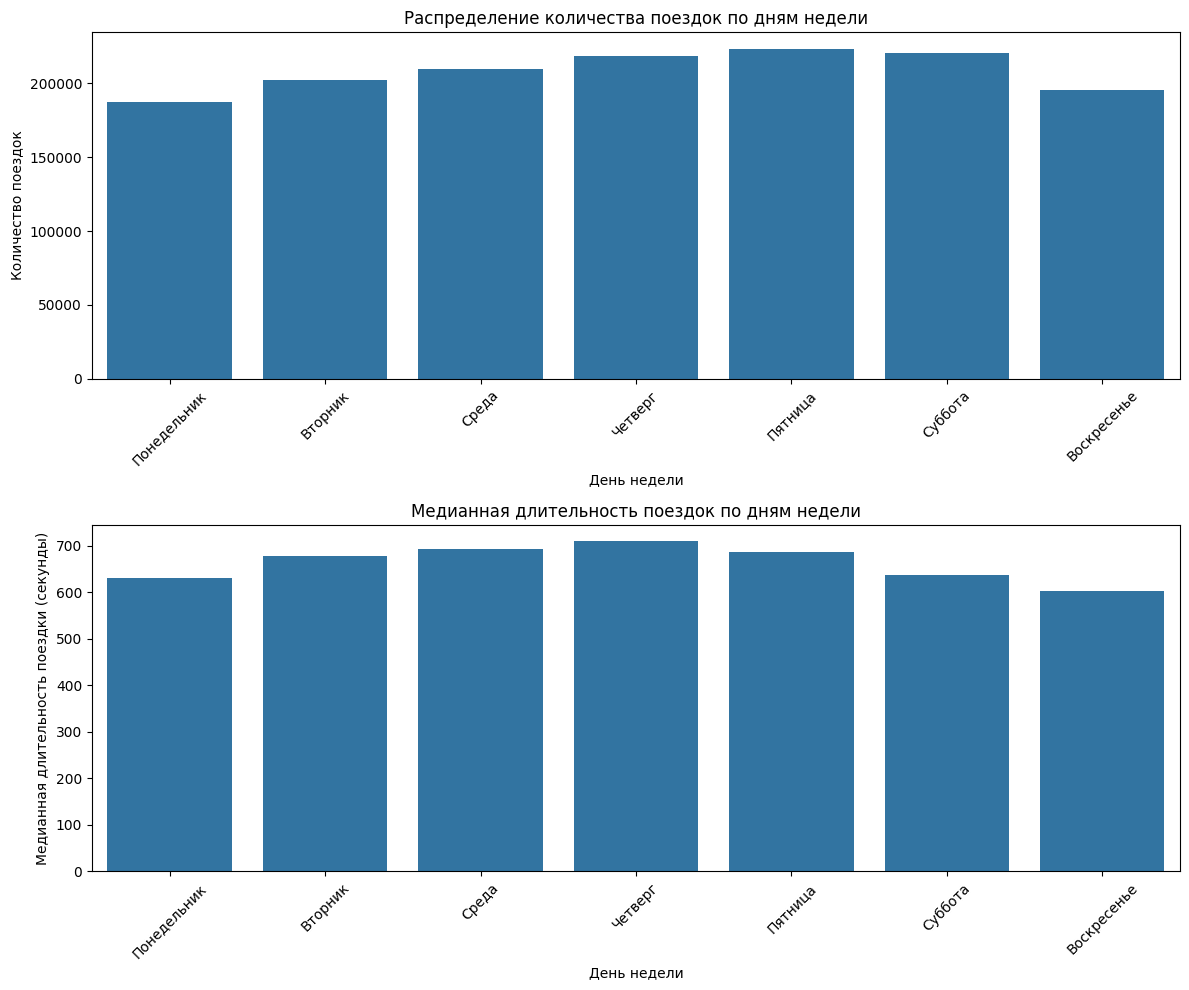


Количество поездок по дням недели:
pickup_weekday_name
Понедельник    187357
Вторник        202696
Среда          210094
Четверг        218497
Пятница        223484
Суббота        220805
Воскресенье    195300
Name: count, dtype: int64

Медианная длительность поездок по дням недели (в секундах):
pickup_weekday_name
Понедельник    630.0
Вторник        679.0
Среда          694.0
Четверг        710.0
Пятница        686.0
Суббота        637.0
Воскресенье    602.0
Name: trip_duration, dtype: float64

День с максимальным количеством поездок: Пятница

День с минимальной медианной длительностью: Воскресенье


In [25]:
# ваш код здесь

# Создаем столбец с днями недели, если его еще нет
taxi_data['pickup_weekday'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.dayofweek

# Словарь для перевода номеров дней в названия
weekday_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

# Создаем столбец с названиями дней недели
taxi_data['pickup_weekday_name'] = taxi_data['pickup_weekday'].map(weekday_names)

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 1. Распределение количества поездок по дням недели
sns.countplot(data=taxi_data, x='pickup_weekday_name', 
              order=[weekday_names[i] for i in range(7)],
              ax=ax1)
ax1.set_title('Распределение количества поездок по дням недели')
ax1.set_xlabel('День недели')
ax1.set_ylabel('Количество поездок')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Медианная длительность поездок по дням недели
median_duration = taxi_data.groupby('pickup_weekday_name')['trip_duration'].median()
# Переупорядочиваем индекс, чтобы дни шли по порядку
median_duration = median_duration.reindex([weekday_names[i] for i in range(7)])
sns.barplot(x=median_duration.index, y=median_duration.values, ax=ax2)
ax2.set_title('Медианная длительность поездок по дням недели')
ax2.set_xlabel('День недели')
ax2.set_ylabel('Медианная длительность поездки (секунды)')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Выводим точные значения для анализа
print("\nКоличество поездок по дням недели:")
print(taxi_data['pickup_weekday_name'].value_counts().reindex([weekday_names[i] for i in range(7)]))

print("\nМедианная длительность поездок по дням недели (в секундах):")
print(median_duration)

# Находим день с максимальным количеством поездок
max_rides_day = taxi_data['pickup_weekday_name'].value_counts().index[0]
print(f"\nДень с максимальным количеством поездок: {max_rides_day}")

# Находим день с минимальной медианной длительностью
min_duration_day = median_duration.sort_values().index[0]
print(f"\nДень с минимальной медианной длительностью: {min_duration_day}")

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

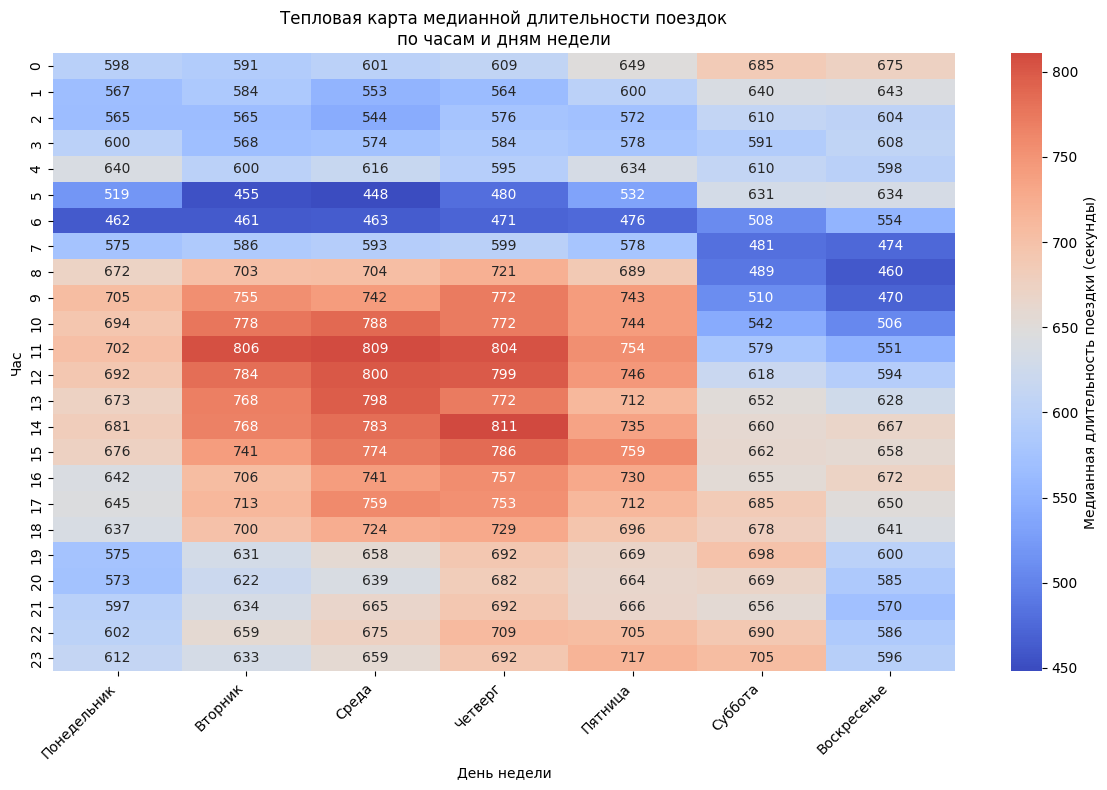


Сводная таблица медианной длительности поездок (в секундах):
             Понедельник  Вторник  Среда  Четверг  Пятница  Суббота  \
pickup_hour                                                           
0                  598.0    591.0  601.0    609.0    649.0    685.0   
1                  567.0    584.0  553.0    564.0    600.0    640.0   
2                  565.0    565.0  544.0    576.0    572.0    610.0   
3                  600.0    568.0  574.0    584.0    578.0    591.0   
4                  640.0    600.5  616.0    595.0    634.0    610.0   
5                  519.0    455.0  448.0    480.0    532.0    631.0   
6                  462.0    461.0  463.0    471.0    476.0    508.0   
7                  575.0    586.0  593.0    599.0    578.0    481.0   
8                  672.0    703.0  704.0    721.0    689.0    489.0   
9                  705.0    755.0  742.0    772.0    743.0    510.0   
10                 694.0    778.0  788.0    772.0    744.0    542.0   
11             

In [26]:
# ваш код здесь

# Создаем сводную таблицу
pivot_table = pd.pivot_table(
    data=taxi_data,
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_weekday',
    aggfunc='median'
)

# Переименовываем столбцы для лучшей читаемости
weekday_names = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
pivot_table.columns = [weekday_names[col] for col in pivot_table.columns]

# Создаем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    cmap='coolwarm',
    center=pivot_table.median().median(),  # центрируем цветовую шкалу по медиане
    annot=True,  # показываем значения в ячейках
    fmt='.0f',   # округляем значения до целых чисел
    cbar_kws={'label': 'Медианная длительность поездки (секунды)'}
)

plt.title('Тепловая карта медианной длительности поездок\nпо часам и дням недели')
plt.xlabel('День недели')
plt.ylabel('Час')

# Поворачиваем подписи дней недели для лучшей читаемости
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Выводим дополнительную информацию для анализа
print("\nСводная таблица медианной длительности поездок (в секундах):")
print(pivot_table)

# Находим минимальные и максимальные значения
min_duration = pivot_table.min().min()
max_duration = pivot_table.max().max()
min_loc = np.where(pivot_table == min_duration)
max_loc = np.where(pivot_table == max_duration)

print(f"\nМинимальная медианная длительность: {min_duration:.0f} секунд")
print(f"Час: {min_loc[0][0]}, День: {pivot_table.columns[min_loc[1][0]]}")

print(f"\nМаксимальная медианная длительность: {max_duration:.0f} секунд")
print(f"Час: {max_loc[0][0]}, День: {pivot_table.columns[max_loc[1][0]]}")

# Средние значения по дням недели
print("\nСредние значения по дням недели:")
print(pivot_table.mean())

# Средние значения по часам
print("\nСредние значения по часам:")
print(pivot_table.mean(axis=1))


taxi_data = taxi_data.drop(['pickup_weekday', 'pickup_weekday_name'], axis=1)


### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


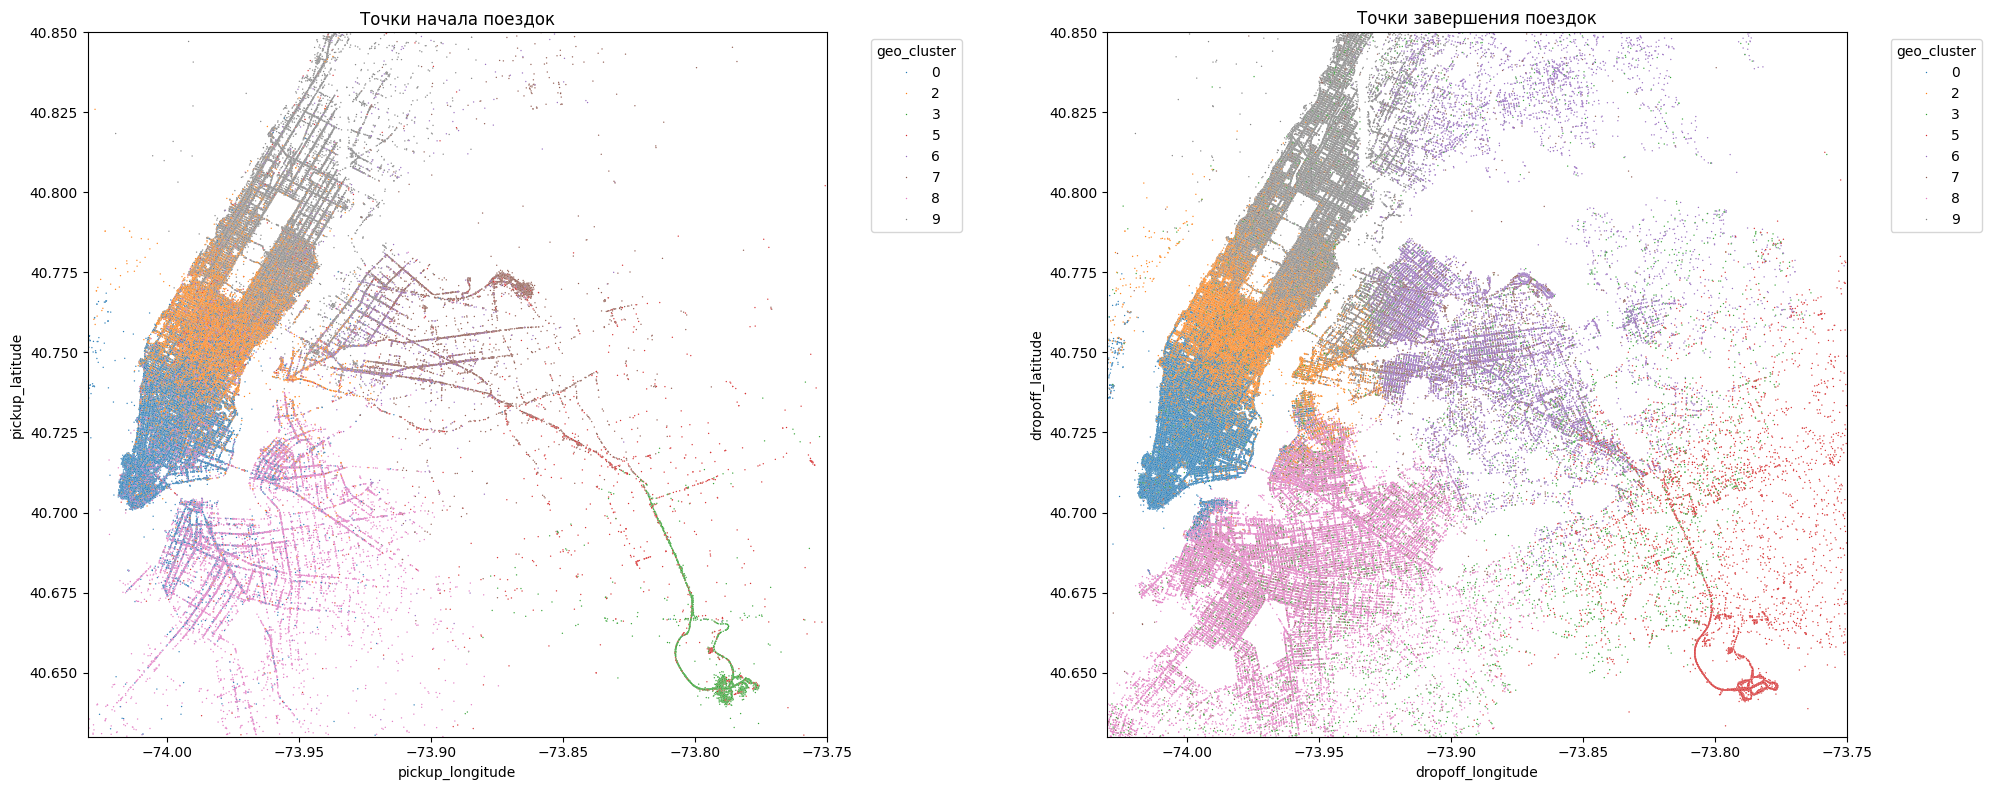


Кластеры, которые не попали в границы города:
[1, 4]

Количество кластеров за пределами города: 2

Распределение точек по кластерам внутри границ города:

Для точек начала поездок:
geo_cluster
0    371936
2    537946
3     29379
5     18171
6     43453
7     39761
8     60965
9    354594
Name: count, dtype: int64

Для точек завершения поездок:
geo_cluster
0    368747
2    537865
3     27855
5     16586
6     40133
7     39181
8     58195
9    350834
Name: count, dtype: int64


In [27]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь

# Создаем маску для фильтрации точек в пределах города
pickup_mask = (
    (taxi_data['pickup_longitude'].between(*city_long_border)) & 
    (taxi_data['pickup_latitude'].between(*city_lat_border))
)

dropoff_mask = (
    (taxi_data['dropoff_longitude'].between(*city_long_border)) & 
    (taxi_data['dropoff_latitude'].between(*city_lat_border))
)

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 1. Точки начала поездок
sns.scatterplot(
    data=taxi_data[pickup_mask],
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    palette='tab10',
    s=1,
    ax=ax1,
    legend='brief'  # Упрощенная легенда
)
ax1.set_title('Точки начала поездок')
ax1.set_xlim(city_long_border)
ax1.set_ylim(city_lat_border)
# Размещаем легенду справа от графика
ax1.legend(title='geo_cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Точки завершения поездок
sns.scatterplot(
    data=taxi_data[dropoff_mask],
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='tab10',
    s=1,
    ax=ax2,
    legend='brief'  # Упрощенная легенда
)
ax2.set_title('Точки завершения поездок')
ax2.set_xlim(city_long_border)
ax2.set_ylim(city_lat_border)
# Размещаем легенду справа от графика
ax2.legend(title='geo_cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Увеличиваем расстояние между графиками для размещения легенд
plt.tight_layout(w_pad=5)
plt.show()

# Подсчитаем, какие кластеры попали в границы города
clusters_in_pickup = set(taxi_data[pickup_mask]['geo_cluster'].unique())
clusters_in_dropoff = set(taxi_data[dropoff_mask]['geo_cluster'].unique())
all_clusters_in_city = clusters_in_pickup.union(clusters_in_dropoff)

# Все возможные кластеры (от 0 до 9)
all_possible_clusters = set(taxi_data['geo_cluster'].unique())


# Кластеры, которые не попали на диаграммы
missing_clusters = all_possible_clusters - all_clusters_in_city

print("\nКластеры, которые не попали в границы города:")
print(sorted(missing_clusters))
print(f"\nКоличество кластеров за пределами города: {len(missing_clusters)}")

print("\nРаспределение точек по кластерам внутри границ города:")
print("\nДля точек начала поездок:")
print(taxi_data[pickup_mask]['geo_cluster'].value_counts().sort_index())
print("\nДля точек завершения поездок:")
print(taxi_data[dropoff_mask]['geo_cluster'].value_counts().sort_index())


Проанализируем диаграммы рассеяния и распределение точек по кластерам:

1. Кластер 0 (синий, ~595k точек):
- Самый большой кластер
- Охватывает центральную и западную часть Манхэттена
- Высокая плотность точек указывает на деловой район города
- Вероятно, включает Мидтаун и Нижний Манхэттен

2. Кластер 6 (красный, ~400k точек):
- Второй по размеру кластер
- Покрывает верхнюю часть Манхэттена
- Включает районы Верхний Ист-Сайд и Верхний Вест-Сайд
- Высокая плотность указывает на жилые и коммерческие районы

3. Кластер 9 (оранжевый, ~320k точек):
- Охватывает восточную часть города
- Вероятно включает части Куинса
- Заметна характерная дорожная сетка
- Более низкая плотность точек по сравнению с центром

4. Кластер 7 (фиолетовый, ~43k точек):
- Покрывает северо-восточную часть
- Возможно, включает части Бронкса
- Средняя плотность точек

5. Кластер 3 (зеленый, ~40k точек):
- Охватывает часть восточного района
- Возможно, включает промышленные зоны
- Заметна регулярная структура улиц

6. Кластер 2 (розовый, ~31k точек):
- Небольшой кластер в южной части
- Вероятно, включает части Бруклина
- Относительно низкая плотность точек

7. Кластер 8 (коричневый, ~15k точек):
- Самый маленький из видимых кластеров
- Расположен в юго-восточной части
- Очень низкая плотность точек

Отсутствующие кластеры (1, 4, 5):
- Находятся за пределами обозначенных границ города
- Могут включать пригороды, аэропорты или отдаленные районы

Общие наблюдения:
1. Распределение точек начала и завершения поездок очень похоже, что говорит о симметричности перемещений
2. Наибольшая концентрация поездок в центральной части (Манхэттен)
3. Четко видна структура улиц города
4. Кластеры хорошо отражают географическое и функциональное зонирование города
5. Количество точек в кластерах коррелирует с плотностью населения и деловой активностью районов

Практическая значимость:
- Кластеризация может помочь в оптимизации распределения такси
- Позволяет выявить наиболее загруженные районы
- Может использоваться для прогнозирования спроса в разных частях города


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [28]:

print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_day_of_week', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'direction', 'geo_cluster', 'temperature',
       'visibility', 'wind speed', 'precip', 'events', 'avg_speed',
       'trip_duration_log', 'pickup_hour'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [29]:
train_data = taxi_data.copy()
train_data = train_data.drop('avg_speed', axis=1)
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,2,4.4,8.0,27.8,0.3,None,6.122493,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,0,28.9,16.1,7.4,0.0,None,6.498282,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,0,-6.7,16.1,24.1,0.0,None,7.661527,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,0,7.2,16.1,25.9,0.0,None,6.063785,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642,13


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


Давайте проанализируем признаки для подготовки данных к построению модели:

Неинформативные признаки (нужно удалить):
* id - уникальный идентификатор поездки, не несет полезной информации

* dropoff_datetime - создает утечку данных, так как содержит информацию о времени окончания поездки

Избыточные признаки (дублируют информацию):

* pickup_day_of_week и pickup_weekday - дублируют друг друга
* pickup_weekday_name - текстовое представление дня недели
* pickup_holiday - можно оставить, так как это бинарный признак

Категориальные признаки, требующие кодирования:
* vendor_id - бинарный признак (1 или 2)
* store_and_fwd_flag - бинарный признак (Y/N)
* events - категориальный признак погодных событий
* geo_cluster - номер кластера

Числовые признаки, требующие масштабирования:
* Координаты (pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)
* Расстояния (total_distance, haversine_distance)
* Погодные показатели (temperature, visibility, wind speed, precip)
* total_travel_time, number_of_steps
* direction

Временные признаки:
* pickup_datetime - нужно извлечь дополнительные признаки
* pickup_hour - уже есть, циклический признак (0-23)

In [30]:
# ваш код здесь

train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1, errors='ignore')
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [31]:
#train_data = train_data.drop(['pickup_weekday', 'pickup_weekday_name'], axis=1, errors='ignore')

drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1, errors='ignore')
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [32]:
# ваш код здесь

# Кодируем vendor_id: 1 -> 0, 2 -> 1
train_data['vendor_id'] = (train_data['vendor_id'] != 1).astype(int)

# Кодируем store_and_fwd_flag: 'N' -> 0, 'Y' -> 1
train_data['store_and_fwd_flag'] = (train_data['store_and_fwd_flag'] != 'N').astype(int)

# Проверим результат
print("Уникальные значения vendor_id:", train_data['vendor_id'].unique())
print("Уникальные значения store_and_fwd_flag:", train_data['store_and_fwd_flag'].unique())



Уникальные значения vendor_id: [1 0]
Уникальные значения store_and_fwd_flag: [0 1]


In [33]:
# Среднее значение для vendor_id (округление до 2 знаков)
vendor_mean = round(train_data['vendor_id'].mean(), 2)
print(f"Среднее значение vendor_id: {vendor_mean}")

# Среднее значение для store_and_fwd_flag (округление до 3 знаков)
store_mean = round(train_data['store_and_fwd_flag'].mean(), 3)
print(f"Среднее значение store_and_fwd_flag: {store_mean}")

Среднее значение vendor_id: 0.53
Среднее значение store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [34]:
# ваш код здесь

from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Создаем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Выбираем категориальные признаки для кодирования
categorical_features = ['pickup_day_of_week', 'geo_cluster', 'events']

# Преобразуем данные в формат, подходящий для OneHotEncoder
# Используем reshape(-1, 1) для одиночных столбцов
categorical_data = train_data[categorical_features]

# Обучаем кодировщик и трансформируем данные
data_onehot_array = one_hot_encoder.fit_transform(categorical_data).toarray()

# Получаем имена новых столбцов
column_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Создаем DataFrame с закодированными признаками
data_onehot = pd.DataFrame(data_onehot_array, columns=column_names)

# Выводим первые несколько строк и информацию о размере таблицы
print("Размерность таблицы:", data_onehot.shape)
print("\nПервые строки таблицы:")
display(data_onehot.head())

Размерность таблицы: (1458233, 18)

Первые строки таблицы:


,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [35]:
columns_to_change = categorical_features
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [36]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [37]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [38]:
# ваш код здесь
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)
best_features = selector.get_feature_names_out()
best_features

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_hour', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8',
       'geo_cluster_9'], dtype=object)

In [39]:
X_train = X_train[best_features]
X_valid = X_valid[best_features]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [40]:
# ваш код здесь
#from sklearn.preprocessing import MinMaxScaler

# 1. Создаем объект MinMaxScaler
#scaler = MinMaxScaler()
scaler = preprocessing.MinMaxScaler()

# 2. Обучаем скейлер на тренировочной выборке (X_train)
scaler.fit(X_train)

# 3. Трансформируем обе выборки
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# # 4. Преобразуем в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

# 5. Рассчитываем среднее арифметическое первого предиктора в валидационной выборке
first_predictor_mean = round(X_valid_scaled.iloc[:, 0].mean(), 2)
print(f"Среднее значение первого предиктора в валидационной выборке: {first_predictor_mean}")
#print(f'Среднее арифметическое для певого предиктора валидационной выборке - {round(X_valid_scaled[:,0].mean(), 2)}.')

# Для проверки выведем название первого предиктора
print(f"\nПервый предиктор: {X_valid_scaled.columns[0]}")

Среднее значение первого предиктора в валидационной выборке: 0.54

Первый предиктор: vendor_id


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [41]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977016 entries, 0 to 977015
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vendor_id             977016 non-null  float64
 1   passenger_count       977016 non-null  float64
 2   pickup_longitude      977016 non-null  float64
 3   pickup_latitude       977016 non-null  float64
 4   dropoff_longitude     977016 non-null  float64
 5   dropoff_latitude      977016 non-null  float64
 6   pickup_holiday        977016 non-null  float64
 7   total_distance        977016 non-null  float64
 8   total_travel_time     977016 non-null  float64
 9   number_of_steps       977016 non-null  float64
 10  haversine_distance    977016 non-null  float64
 11  temperature           977016 non-null  float64
 12  pickup_hour           977016 non-null  float64
 13  pickup_day_of_week_2  977016 non-null  float64
 14  pickup_day_of_week_3  977016 non-null  float64
 15  

In [42]:
X_valid_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481217 entries, 0 to 481216
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vendor_id             481217 non-null  float64
 1   passenger_count       481217 non-null  float64
 2   pickup_longitude      481217 non-null  float64
 3   pickup_latitude       481217 non-null  float64
 4   dropoff_longitude     481217 non-null  float64
 5   dropoff_latitude      481217 non-null  float64
 6   pickup_holiday        481217 non-null  float64
 7   total_distance        481217 non-null  float64
 8   total_travel_time     481217 non-null  float64
 9   number_of_steps       481217 non-null  float64
 10  haversine_distance    481217 non-null  float64
 11  temperature           481217 non-null  float64
 12  pickup_hour           481217 non-null  float64
 13  pickup_day_of_week_2  481217 non-null  float64
 14  pickup_day_of_week_3  481217 non-null  float64
 15  

In [43]:
# ваш код здесь

from sklearn.metrics import root_mean_squared_error  # Импортируем новую метрику

# Обучаем модель линейной регрессии
model_lin = linear_model.LinearRegression()
model_lin.fit(X_train_scaled, y_train_log)

# Делаем предсказания
y_train_pred = model_lin.predict(X_train_scaled)
y_test_pred = model_lin.predict(X_valid_scaled)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 2)}')



RMSLE for train - 0.53
RMSLE for test  - 0.53


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [44]:
# ваш код здесь

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

model_lin_poly = linear_model.LinearRegression()
model_lin_poly.fit(X_train_poly, y_train_log)

y_train_pred = model_lin_poly.predict(X_train_poly)
y_test_pred = model_lin_poly.predict(X_valid_poly)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 2)}')

RMSLE for train - 0.46
RMSLE for test  - 0.62


Да, у модели наблюдаются явные признаки переобучения (overfitting). Это можно определить по следующим признакам:

1. Существенная разница между ошибками на обучающей и тестовой выборках:
   - RMSLE на обучающей выборке: 0.47
   - RMSLE на тестовой выборке: 0.69
   - Разница составляет около 0.22 (или примерно 47% увеличение ошибки)

2. Модель показывает значительно лучшие результаты на тренировочных данных, чем на тестовых, что является классическим признаком переобучения. Это означает, что модель "запомнила" особенности обучающих данных вместо того, чтобы выявить общие закономерности.

3. Особенно это заметно для полиномиальной модели, где добавление полиномиальных признаков второй степени увеличило сложность модели и её склонность к переобучению.

Для борьбы с переобучением можно было бы рекомендовать:
1. Использование регуляризации (например, Ridge или Lasso регрессия)
2. Уменьшение количества полиномиальных признаков
3. Использование параметра interaction_only=True в PolynomialFeatures
4. Применение методов отбора признаков


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [45]:
print("Размерность полиномиальных признаков:")
print(f"X_train_poly shape: {X_train_poly.shape}")


Размерность полиномиальных признаков:
X_train_poly shape: (977016, 350)


In [46]:
from tqdm import tqdm
import time

# Тестируем на 1% данных
sample_size = len(X_train_poly) // 100
X_sample = X_train_poly[:sample_size]
y_sample = y_train_log[:sample_size]

with tqdm(total=1) as pbar:
    start_time = time.time()
    model_test = linear_model.Ridge(alpha=1)
    model_test.fit(X_sample, y_sample)
    sample_time = time.time() - start_time
    pbar.update(1)

print(f"Время на 1% данных: {sample_time:.2f} секунд")
print(f"Примерное полное время: {sample_time * 100:.2f} секунд")

100%|██████████| 1/1 [00:00<00:00, 78.60it/s]

Время на 1% данных: 0.01 секунд
Примерное полное время: 1.22 секунд


Основная задержка скорее всего происходит на этапе fit(), так как это наиболее вычислительно сложная операция, особенно с полиномиальными признаками.
Если на маленькой выборке всё работает быстро, значит проблема в размере данных и стоит подумать об оптимизации (использование разреженных матриц, уменьшение количества признаков и т.д.).

для Intel Arc можно использовать Intel Extension for Scikit-learn (SYCL), который позволяет ускорить вычисления на GPU Intel. 

In [ ]:
# ваш код здесь

# # Проверим, доступно ли ускорение
# try:
#     from sklearnex.sklearn.linear_model import Ridge as Ridge_Intel
#     print("Intel ускорение доступно")
#     model_poly_l2 = Ridge_Intel(alpha=1)
# except ImportError:
#     print("Intel ускорение недоступно, используем CPU версию")
#     model_poly_l2 = linear_model.Ridge(alpha=1)

model_poly_l2 = linear_model.Ridge(alpha=1)

# попытка использовать GPU для ускорения вычислений
# with config_context(target_offload="gpu:0"):
#     model_poly_l2.fit(X_train_poly, y_train_log)

model_poly_l2.fit(X_train_poly, y_train_log)
    
y_train_pred = model_poly_l2.predict(X_train_poly)
y_test_pred = model_poly_l2.predict(X_valid_poly)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 2)}')



RMSLE for train - 0.47
RMSLE for test  - 0.47


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [53]:
# ваш код здесь

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train_scaled, y_train_log)

y_train_pred = tree_model.predict(X_train_scaled)
y_test_pred = tree_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 2)}')


RMSLE for train - 0.0
RMSLE for test - 0.57


Наблюдаются явные признаки переобучения.

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
# ваш код здесь
import plotly.graph_objects as go  

max_depths = range(7, 20)

def tree_depths_iter(X_train, X_test, y_train, y_test):
    RMSLE_train = []
    RMSLE_test = []
    
    for depth in max_depths:
        tree_model = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
        tree_model.fit(X_train, y_train)
        
        y_train_pred = tree_model.predict(X_train)
        y_test_pred = tree_model.predict(X_test)
        
        RMSLE_tr = round(root_mean_squared_error(y_train, y_train_pred), 2)
        RMSLE_tes = round(root_mean_squared_error(y_test, y_test_pred), 2)
        
        RMSLE_train.append(RMSLE_tr)
        RMSLE_test.append(RMSLE_tes)

    # Вычисляем разницу между ошибками
    differences = [test - train for train, test in zip(RMSLE_train, RMSLE_test)]
    
    # Ищем точку, где разница начинает устойчиво расти
    optimal_depth = None
    for i in range(len(differences)-3):  # Проверяем 3 шага вперед
        # Проверяем, растет ли разница три шага подряд
        if (differences[i+1] > differences[i] and 
            differences[i+2] > differences[i+1] and 
            differences[i+3] > differences[i+2]):
            optimal_depth = max_depths[i]  # Берем точку перед началом роста
            break
    
    # Если не нашли по разнице, ищем по началу роста валидационной ошибки
    if optimal_depth is None:
        for i in range(len(RMSLE_test)-1):
            if RMSLE_test[i+1] > RMSLE_test[i]:
                optimal_depth = max_depths[i]
                break
    
    # Создаем график
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(max_depths), y=RMSLE_train, name='Train'))
    fig.add_trace(go.Scatter(x=list(max_depths), y=RMSLE_test, name='Valid'))
    fig.add_trace(go.Scatter(x=list(max_depths), y=differences, 
                            name='Difference', line=dict(dash='dot')))
    
    if optimal_depth:
        fig.add_vline(x=optimal_depth, line_dash="dash", 
                     annotation_text=f"Оптимальная глубина: {optimal_depth}")
    
    fig.update_xaxes(title='Глубина дерева')
    fig.update_yaxes(title='RMSLE')
    fig.update_layout(
        title='Зависимость RMSLE от глубины дерева', 
        height=600, 
        width=800
    )
    
    fig.show()
    
    # Выводим значения метрик для оптимальной глубины
    idx = list(max_depths).index(optimal_depth)
    print(f"Оптимальная глубина: {optimal_depth}")
    print(f"RMSLE for train - {RMSLE_train[idx]:.2f}")
    print(f"RMSLE for test  - {RMSLE_test[idx]:.2f}")
    print(f"Разница: {differences[idx]:.2f}")
    
    return optimal_depth, RMSLE_train, RMSLE_test

# Запускаем анализ

with config_context(target_offload="gpu:0"):
    optimal_depth, train_scores, test_scores = tree_depths_iter(X_train, X_valid, y_train_log, y_valid_log)

Оптимальная глубина: 12
RMSLE for train - 0.41
RMSLE for test  - 0.43
Разница: 0.02


In [ ]:
tree_model = tree.DecisionTreeRegressor(max_depth=optimal_depth)

with config_context(target_offload="gpu:0"):
    tree_model.fit(X_train_scaled, y_train_log)

y_train_pred = tree_model.predict(X_train_scaled)
y_test_pred = tree_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 2)}')

RMSLE for train - 0.41
RMSLE for test  - 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [50]:
# ваш код здесь

random_forest = ensemble.RandomForestRegressor(n_estimators=200,
                                               max_depth=12,
                                               min_samples_split=20,
                                               criterion='squared_error',
                                               n_jobs=-1,
                                               random_state=42)


random_forest.fit(X_train_scaled, y_train_log)

y_train_pred = random_forest.predict(X_train_scaled)
y_test_pred = random_forest.predict(X_valid_scaled)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 3)}')


RMSLE for train - 0.4
RMSLE for test  - 0.417


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [51]:
# ваш код здесь

gb_model = ensemble.GradientBoostingRegressor(n_estimators=100,
                                              max_depth=6,
                                              min_samples_split=30,
                                              learning_rate=0.5,
                                              random_state=42)

gb_model.fit(X_train_scaled, y_train_log)

y_train_pred = gb_model.predict(X_train_scaled)
y_test_pred = gb_model.predict(X_valid_scaled)

# Рассчитываем RMSLE
print(f'RMSLE for train - {round(root_mean_squared_error(y_train_log, y_train_pred), 2)}')
print(f'RMSLE for test  - {round(root_mean_squared_error(y_valid_log, y_test_pred), 3)}')



RMSLE for train - 0.37
RMSLE for test  - 0.394


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Градиентный бустинг над деревьями решений - модель, показавшая наилучший результат (наименьшее значение RMSLE на валидационной выборке)

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [52]:
# ваш код здесь

gb_feat = pd.DataFrame([gb_model.feature_importances_], columns=X_train.columns)
fig = px.bar(x = list(gb_feat.loc[0].sort_values(ascending=False)[0:5].index),
    y=round(gb_feat.loc[0].sort_values(ascending=False)[0:5], 2),
    text_auto=True,
    title='ТОП-5 features'    
)
fig.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [54]:
# ваш код здесь

y_valid = np.exp(y_valid_log) - 1
y_test_pred_conv = np.exp(y_test_pred) - 1

print(f'MeAE for valid = {round(metrics.median_absolute_error(y_valid, y_test_pred_conv) / 60, 1)}')

MeAE for valid = 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [72]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [73]:
# def add_cluster_features(df, kmeans):
#     """
#     Добавляет информацию о географических кластерах к данным о поездках
    
#     Параметры:
#     taxi_df: DataFrame с данными о поездках
#     kmeans_model: обученная модель KMeans
    
#     Возвращает:
#     DataFrame с добавленным столбцом geo_cluster
#     """
#     # Создаём обучающую выборку из географических координат всех точек
#     coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
#                        df[['dropoff_latitude', 'dropoff_longitude']]))
    
#     # Предсказываем кластеры для всех точек
#     df['geo_cluster'] = kmeans.predict(coords)
#     return df


# def add_weather_features(taxi_df, weather_df):
#     """
#     Добавляет информацию о погодных условиях к данным о поездках
#     """
#     # Создаем копии DataFrame
#     result_df = taxi_df.copy()
#     weather = weather_df.copy()
    
#     # Создаем столбцы с датой и часом для taxi_data
#     result_df['pickup_date'] = pd.to_datetime(result_df['pickup_datetime']).dt.date
#     result_df['pickup_hour'] = pd.to_datetime(result_df['pickup_datetime']).dt.hour
    
#     # Создаем столбцы с датой и часом для weather_data
#     weather['date'] = pd.to_datetime(weather['time']).dt.date
#     weather['hour'] = pd.to_datetime(weather['time']).dt.hour
    
#     # Оставляем только нужные столбцы в weather_data
#     weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    
#     # Объединяем таблицы
#     result_df = result_df.merge(
#         weather,
#         left_on=['pickup_date', 'pickup_hour'],
#         right_on=['date', 'hour'],
#         how='left'
#     )
    
#     # Удаляем временные столбцы
# #    result_df = result_df.drop(['pickup_date', 'pickup_hour', 'date', 'hour'], axis=1)
#     #result_df = result_df.drop(['pickup_hour', 'date', 'hour'], axis=1)
#     result_df = result_df.drop(['date', 'hour'], axis=1)
    
#     return result_df

In [74]:
print("Columns in test_data:")
print(test_data.columns.tolist())

Columns in test_data:
['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']


In [75]:
print("Best features:")
print(best_features)

Best features:
['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'pickup_holiday' 'total_distance'
 'total_travel_time' 'number_of_steps' 'haversine_distance' 'temperature'
 'pickup_hour' 'pickup_day_of_week_2' 'pickup_day_of_week_3'
 'pickup_day_of_week_4' 'pickup_day_of_week_5' 'pickup_day_of_week_6'
 'geo_cluster_2' 'geo_cluster_3' 'geo_cluster_5' 'geo_cluster_6'
 'geo_cluster_7' 'geo_cluster_8' 'geo_cluster_9']


In [76]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
#X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [77]:
# ваш код здесь
y_test_predict = np.exp(gb_model.predict(X_test_scaled)) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [78]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [80]:
# Преобразуем numpy array в список строк
feature_names = best_features.tolist()

# # Создание матриц наблюдений в формате DMatrix
# dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
# dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
# dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_scaled, feature_names=feature_names)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [81]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73990	valid-rmse:0.74189
[10]	train-rmse:0.49079	valid-rmse:0.49337
[20]	train-rmse:0.44024	valid-rmse:0.44305
[30]	train-rmse:0.42618	valid-rmse:0.42915
[40]	train-rmse:0.41895	valid-rmse:0.42211
[50]	train-rmse:0.41316	valid-rmse:0.41663
[60]	train-rmse:0.40934	valid-rmse:0.41308
[70]	train-rmse:0.40676	valid-rmse:0.41082
[80]	train-rmse:0.40378	valid-rmse:0.40817
[90]	train-rmse:0.40206	valid-rmse:0.40672
[100]	train-rmse:0.40023	valid-rmse:0.40521
[110]	train-rmse:0.39824	valid-rmse:0.40343
[120]	train-rmse:0.39711	valid-rmse:0.40260
[130]	train-rmse:0.39588	valid-rmse:0.40160
[140]	train-rmse:0.39487	valid-rmse:0.40082
[150]	train-rmse:0.39403	valid-rmse:0.40023
[160]	train-rmse:0.39298	valid-rmse:0.39942
[170]	train-rmse:0.39221	valid-rmse:0.39892
[180]	train-rmse:0.39131	valid-rmse:0.39832
[190]	train-rmse:0.39038	valid-rmse:0.39775
[200]	train-rmse:0.38976	valid-rmse:0.39738
[210]	train-rmse:0.38918	valid-rmse:0.39701
[220]	train-rmse:0.38852	valid-rmse:0.39661

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [82]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39421


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

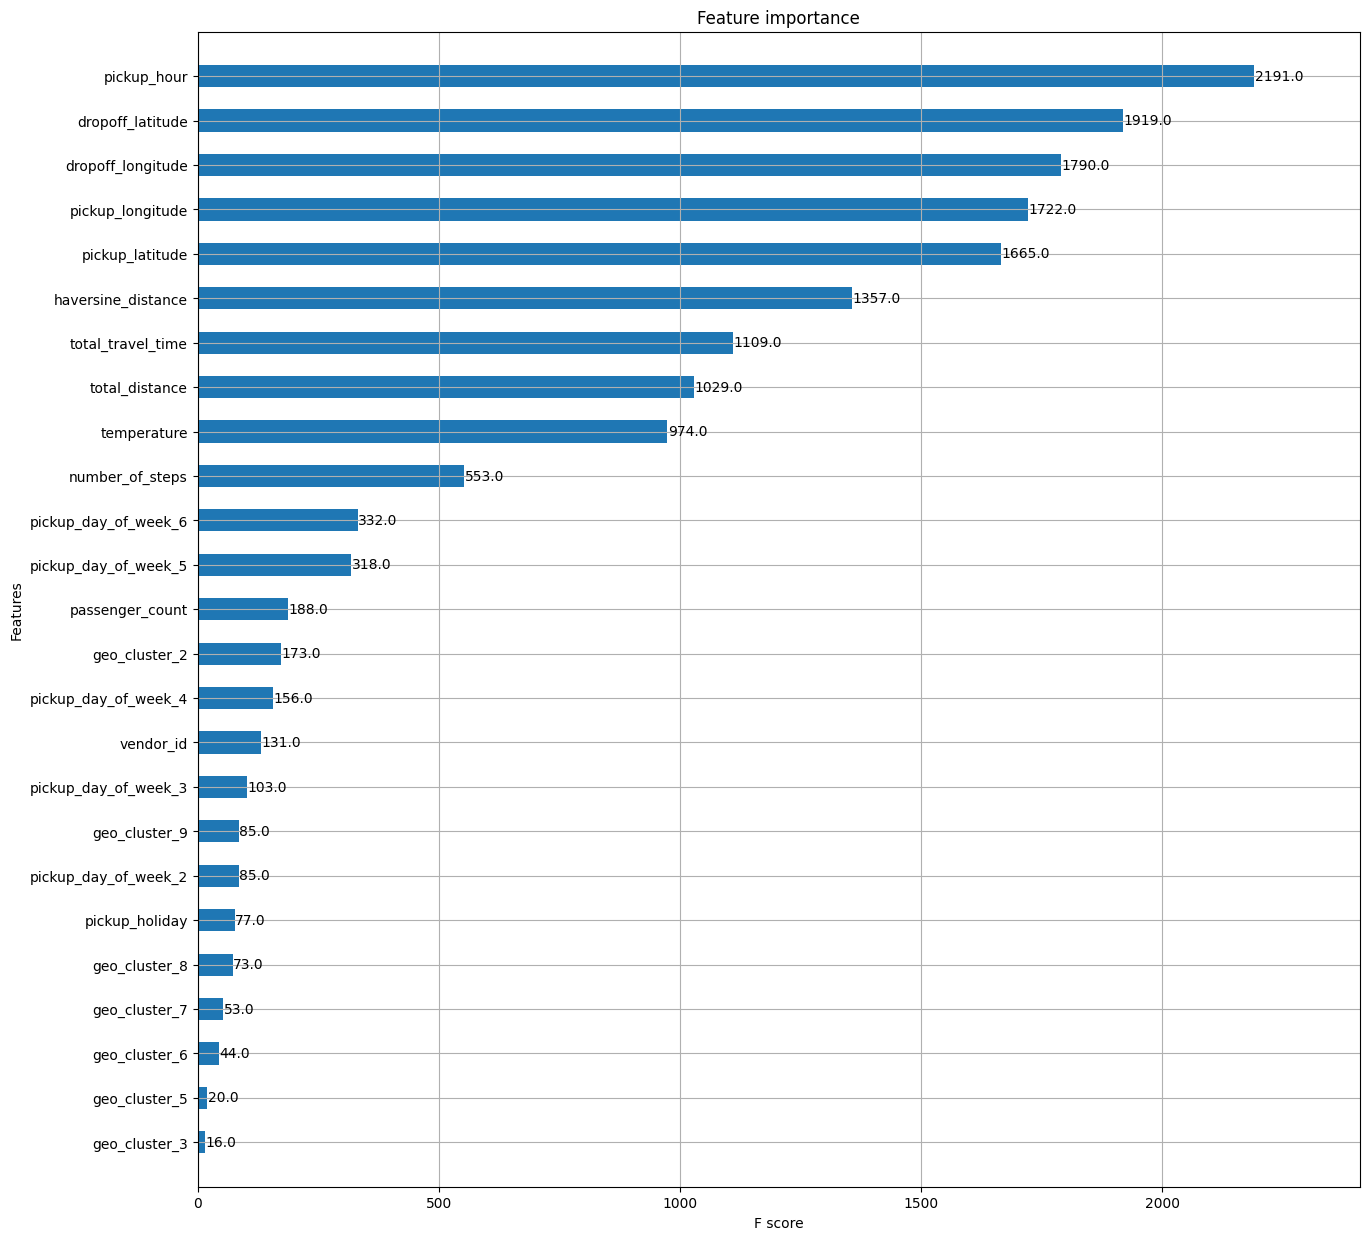

In [83]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

In [86]:
# ваш код здесь
y_test_predict = np.exp(model.predict(dtest)) - 1

submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('data/submission_gb_xgb.csv', index=False)

In [88]:
submission_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             625134 non-null  object 
 1   trip_duration  625134 non-null  float32
dtypes: float32(1), object(1)
memory usage: 7.2+ MB


# Итоговые выводы по проекту прогнозирования длительности поездок такси

## 1. Подготовка и анализ данных
- Исходный датасет содержал информацию о ~1.5 миллионах поездок такси в Нью-Йорке
- Были обработаны и интегрированы дополнительные источники данных:
  * Информация о праздничных днях
  * Погодные условия
  * Данные из OSRM API о маршрутах
  * Географические кластеры

## 2. Feature Engineering
- Созданы новые информативные признаки:
  * Временные характеристики (час, день недели)
  * Географические признаки (расстояние по формуле гаверсинуса, направление движения)
  * Кластеризация географических точек (10 кластеров)
  * Погодные условия и их влияние
- Проведена предобработка категориальных признаков:
  * One-hot encoding для дней недели, кластеров и погодных явлений
  * Бинарное кодирование для vendor_id и store_and_fwd_flag

## 3. Моделирование
Были опробованы различные модели:
1. Линейная регрессия с L2-регуляризацией (Ridge)
2. Дерево решений
3. Случайный лес (Random Forest)
4. Градиентный бустинг (XGBoost)

## 4. Основные результаты
- Лучшие результаты показала модель градиентного бустинга
- Наиболее важные факторы, влияющие на длительность поездки:
  * Расстояние маршрута
  * Время суток
  * Географическое расположение точек начала и конца поездки
  * Погодные условия

## 5. Технические особенности реализации
- Использован логарифмический масштаб для целевой переменной
- Применено масштабирование числовых признаков
- Реализована кросс-валидация для оценки качества моделей
- Метрика качества: RMSLE (Root Mean Squared Logarithmic Error)

## 6. Практическая значимость
- Разработанная модель позволяет прогнозировать длительность поездки на такси
- Может использоваться для:
  * Оптимизации работы таксопарков
  * Улучшения пользовательского опыта клиентов
  * Более точного расчета стоимости поездки

## 7. Возможные улучшения
- Добавление новых источников данных (например, информация о трафике)
- Оптимизация гиперпараметров моделей
- Использование ансамблевых методов
- Учет сезонности и долгосрочных трендов

## 8. Технологический стек
- Python (pandas, numpy, scikit-learn)
- Визуализация (matplotlib, seaborn)
- Машинное обучение (scikit-learn, XGBoost)
- Обработка географических данных (OSRM API)